<a href="https://colab.research.google.com/github/wallacelw/Price-Forecasting-With-LSTM/blob/main/Prices_Forecasting_Best.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Datasets available @

BTC, AAPL, MSFT, TSLA, ^IXIC(NASDAQ), ^BVSP(IBOVESPA):
https://finance.yahoo.com/

S&P 500:
https://www.kaggle.com/datasets/andrewmvd/sp-500-stocks?select=sp500_index.csv

## Preprocessing

In [ ]:
import pandas as pd
import datetime

def str_to_datetime(s):
    """ Converts a string object to the respective datetime objects"""

    year, month, day = [int(i) for i in s.split('-')]
    return datetime.datetime(year=year, month=month, day=day)


price_dict = {
    "Adj Close" : "Price",
    "S&P500" : "Price",
}

def load_df(filename):
    """
    Create dataframe, filter only Price column,
    convert date to datetime and make it the index
    """

    df = pd.read_csv(filename)
    df.rename(columns = price_dict, inplace = True)

    # Univariate analysis
    df = df[["Date", "Price"]]

    # Convert date type objects to datetime object
    df["Date"] = df["Date"].apply(str_to_datetime)

    # Turn "Date" Column into dataframe index
    df.index = df.pop("Date")

    return df


df = load_df("MSFT.csv")

df

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(df.index, df["Price"])
plt.title("Full Dataset")
plt.show()

In [ ]:
# Choose the amount of days to consider from the dataset
days = 5000 # ~13 years

# numbers of days to consider in the input of the model
lookback = 15 #


def df_to_windowed(fullDF, n=lookback, daysSelected=days):
    """
    Create a windowed Dataframe (converting into a supervised problem).
    Therefore, the last {lookback} days prices will be the (input)
    and will generate the next day price (output)
    """

    tmp_df = pd.DataFrame()
    for i in range(n, 0, -1):
        tmp_df[f"Last-{i} Price"] = fullDF["Price"].shift(periods=i)
    tmp_df["Price"] = fullDF["Price"]

    return tmp_df.dropna()[-daysSelected:]


windowed_df = df_to_windowed(df)

windowed_df

In [ ]:
windowed_df["Price"].describe()

## Models

In [ ]:
# Command to disable GPU:

# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

# model input: (last {lookback} days prices, 1 feature = "price")
models = [
    Sequential([ # CNN+LSTM+Dropout
       layers.Input((lookback, 1)),
       layers.Conv1D(128, kernel_size=3, activation="relu", padding="same"),
       layers.MaxPooling1D(pool_size=2, padding="same"),
       layers.LSTM(128, return_sequences=True),
       layers.Flatten(),
       layers.Dropout(0.3),
       layers.Dense(128),
       layers.Dense(1)
    ]),

    Sequential([ # LSTM
        layers.Input((lookback, 1)),
        layers.LSTM(128, return_sequences=True),
        layers.Flatten(),
        layers.Dropout(0.3),
        layers.Dense(128),
        layers.Dense(1)
    ]),

    Sequential([ # CNN
        layers.Input((lookback, 1)),
        layers.Conv1D(128, kernel_size=3, activation="relu", padding="same"),
        layers.MaxPooling1D(pool_size=2, padding="same"),
        layers.Flatten(),
        layers.Dense(128),
        layers.Dense(1)
    ]),

    Sequential([ # Rede Neural Simples
        layers.Input((lookback, 1)),
        layers.Flatten(),
        layers.Dense(128),
        layers.Dense(128),
        layers.Dense(1)
    ]),
]

2023-11-26 11:27:01.059187: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-26 11:27:01.059247: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-26 11:27:01.059859: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-26 11:27:01.187578: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-26 11:27:03.065090: I tensorflow/compiler/

In [ ]:
for model in models:
    print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 15, 128)           512       
                                                                 
 max_pooling1d (MaxPooling1  (None, 8, 128)            0         
 D)                                                              
                                                                 
 lstm (LSTM)                 (None, 8, 128)            131584    
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 128)               131200    
                                                        

## Model Training

### Auxilary Functions

In [ ]:
# For each year, 60% train, 20% validation, 20% test
def sliding_window_generator(windowed, trainSize=2100, valiSize=450, testSize=450, step=35):
    """
    Sliding Window Generator
    """

    for i in range(0, len(windowed) - trainSize - testSize - valiSize + 1, step):
        train_slice = windowed[i : i+trainSize]
        vali_slice = windowed[i+trainSize : i+trainSize+valiSize]
        test_slice = windowed[i+trainSize+valiSize : i+trainSize+valiSize+testSize]
        yield (train_slice, vali_slice, test_slice)

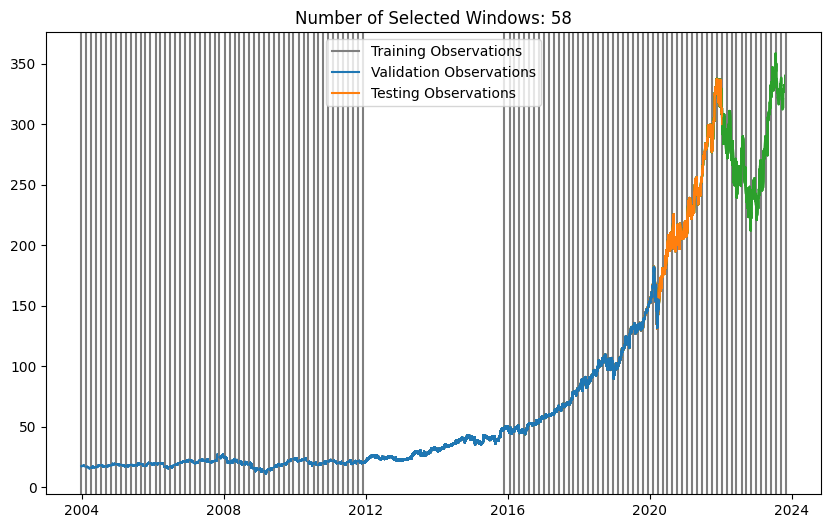

In [ ]:
# Plot windows' intervals and count numbers of windows
plot_generator = sliding_window_generator(windowed_df)
plt.figure(figsize=(10,6))

windows_cnt = 0
for train, vali, test in plot_generator:
    plt.axvline(train.index[0], color="tab:gray")
    plt.plot(train.index, train["Price"], color="tab:blue")
    plt.plot(vali.index, vali["Price"], color="tab:orange")
    plt.plot(test.index, test["Price"], color="tab:green")
    plt.axvline(test.index[-1], color="tab:gray")
    windows_cnt += 1;

plt.title(f"Number of Selected Windows: {windows_cnt}")
plt.legend([
    "Training Observations",
    "Validation Observations",
    "Testing Observations",
])
plt.show()

In [ ]:
def split_xy(windowedNP):
    """
    Split np.array into X and y
    """

    X = windowedNP[:, :-1]
    y = windowedNP[:, -1]
    return (X, y)

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix

def compute_accuracy_and_cm(y_val, y_test, y_pred):
    """
    Computes the accuracy score and the confusion matrix
    For simplicity, zero price change are considered as positive
    """

    sz = len(y_test)
    y_ref = np.append(y_val[-1], y_test)

    y_test_label = np.zeros(sz)
    y_pred_label = np.zeros(sz)

    acc = 0
    for i in range(sz):
        y_test_label[i] = 1 if ((y_test[i] - y_ref[i]) >= 0) else -1
        y_pred_label[i]  = 1 if ((y_pred[i] - y_ref[i]) >= 0) else -1

        if y_test_label[i] == y_pred_label[i]:
            acc += 1

    cm = confusion_matrix(y_true=y_test_label, y_pred=y_pred_label)
    return acc/sz, cm

In [ ]:
from matplotlib import patches
patienceSelected = 50

def plot_loss_curve(history, model_idx, i, patience=patienceSelected):
    aux_list = [(val, i) for i, val in enumerate(history.history['combine_metric'])]
    best = min(aux_list)
    last = len(history.history['combine_metric'])

    plt.figure(figsize=(10,6))
    plt.title(f"Loss Curve for: Model {model_idx}, Window {i}")
    plt.plot(history.history["loss"], label="Training Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.plot(history.history["combine_metric"], label="Combined Loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")

    plt.axvline(last-1, color="tab:gray", ymax=0.3, linestyle='--')
    plt.axvline(last-patience-1, color="tab:gray", ymax=0.3, linestyle='--')
    plt.axvline(best[1], color="tab:red", ymax=0.3, linestyle='--')

    red_patch = patches.Patch(color="tab:red", label=f"best epoch={best[1]}")
    gray_patch = patches.Patch(color="tab:gray", label=f"Early Stop Limits ({last-patience-1}, {last-1})")

    handles, labels = plt.gca().get_legend_handles_labels()
    handles.extend([red_patch, gray_patch])

    plt.legend(handles=handles, loc="upper right")
    plt.show()

In [ ]:
def plot_predictions(dates, ys, metrics, model_idx, i):
    dates_train, dates_vali, dates_test = dates
    y_train, y_vali, y_test, y_result = ys
    rmse, mae, mape, r2, acc = metrics

    plt.figure(figsize=(10,6))
    plt.plot(dates_train, y_train)
    plt.plot(dates_vali, y_vali)
    plt.plot(dates_test, y_test)
    plt.plot(dates_test, y_result)
    plt.legend([
        "Training Observations",
        "Validation Observations",
        "Testing Observations",
        "Testing Predictions"
    ])
    plt.title(f"Model {model_idx}, Window {i}, RMSE={rmse:.3f}, MAE={mae:.3f}, MAPE={mape:.3f}, R2={r2:.3f}")
    plt.show()

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrix(cm, metrics, model_idx, i):
    rmse, mae, mape, r2, acc = metrics

    cm_plt = ConfusionMatrixDisplay(cm, display_labels=["Positive", "Negative"])
    cm_plt.plot()
    cm_plt.ax_.set(
        title= f"Model {model_idx}, Window {i}, Accuracy={acc:.3f}",
        xlabel= "Predicted Price Change",
        ylabel= "Actual Price Change"
    )
    plt.show()

In [ ]:
from keras.callbacks import EarlyStopping , Callback, ModelCheckpoint
import h5py

class CombineCallback(Callback):
    def __init__(self, **kargs):
        super(CombineCallback, self).__init__(**kargs)
    def on_epoch_end(self, epoch, logs={}):
        val_factor = 0.2 # 80% training loss, 20% validation loss
        logs['combine_metric'] = val_factor * logs['val_loss'] + (1-val_factor) * logs['loss']

combined_cb = CombineCallback()
model_checkpoint = ModelCheckpoint(
    filepath="tmp_best_model.h5",
    monitor="combine_metric",
    mode="min",
    save_best_only=True,
    save_weights_only=True,
    verbose=False
)
earlyStop = EarlyStopping(monitor="combine_metric", min_delta=0, patience=patienceSelected, mode="min", verbose=False)

### Main Function

2023-11-26 11:27:06.036996: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-11-26 11:27:06.282901: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-26 11:27:06.937942: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f6b4401e7f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-26 11:27:06.937978: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1070, Compute Capability 6.1
2023-11-26 11:27:06.944112: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-26 11:27:06.994678: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


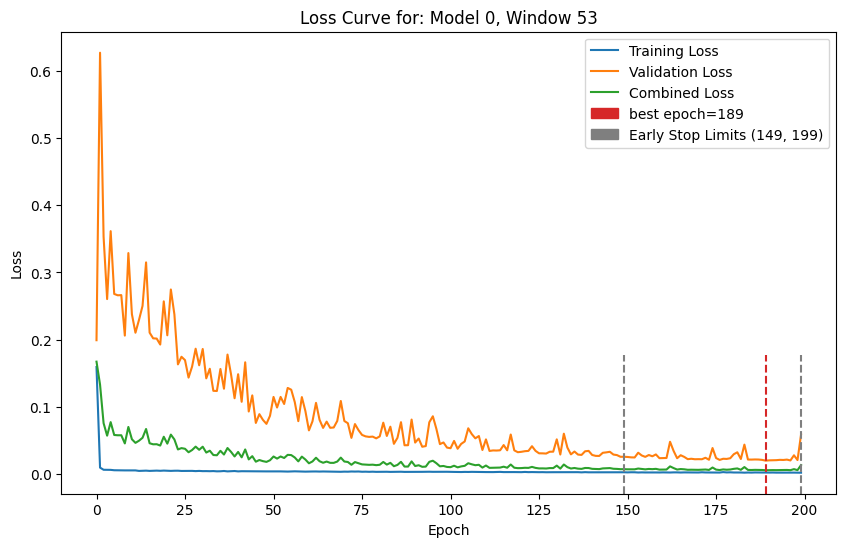

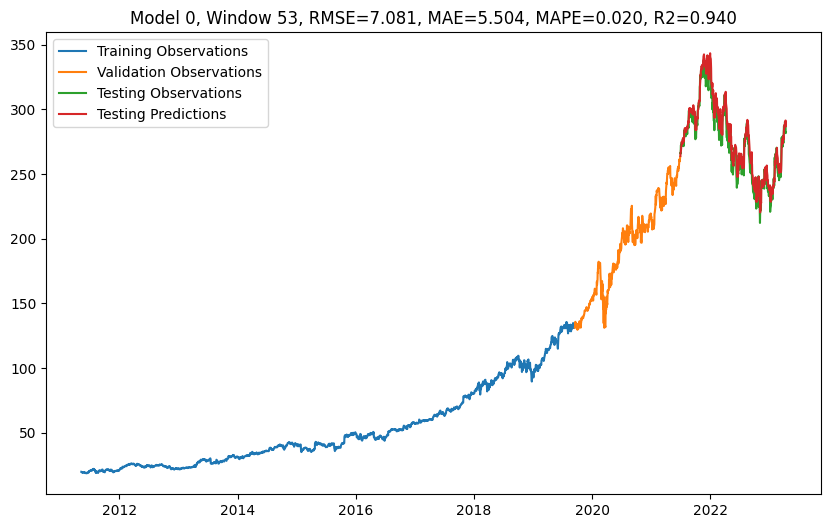

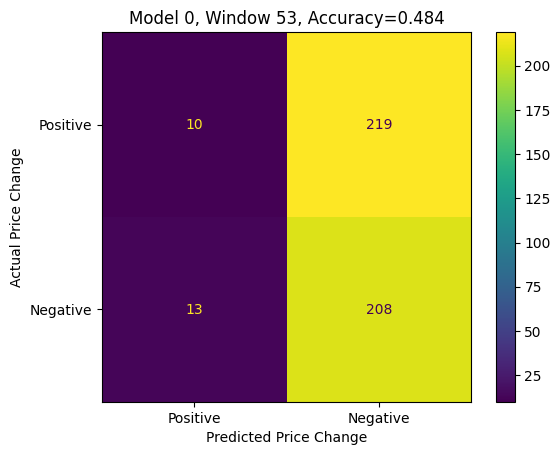

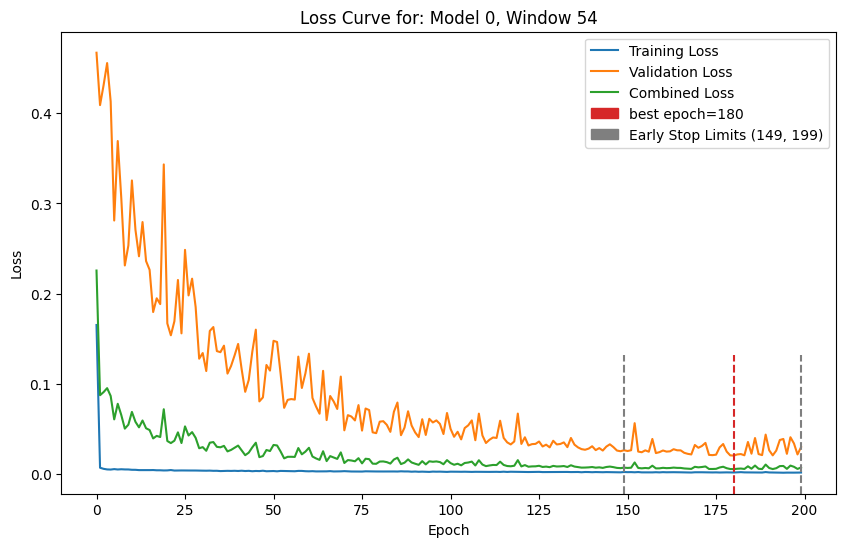

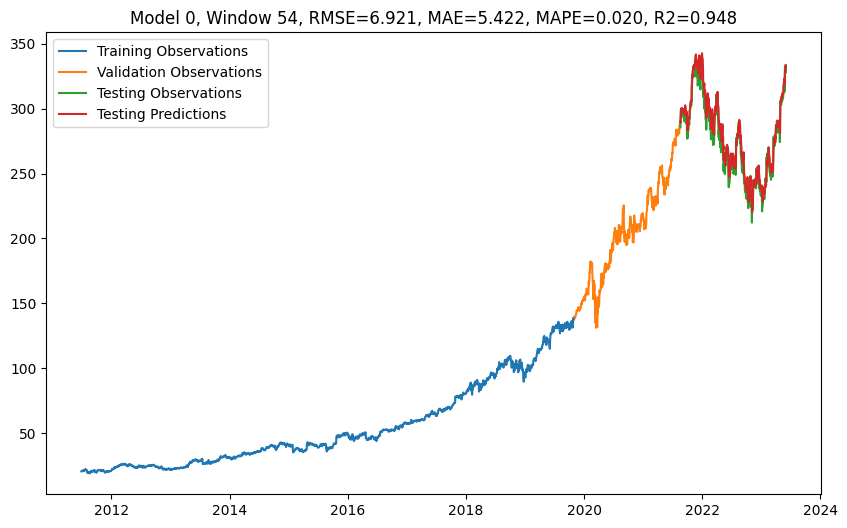

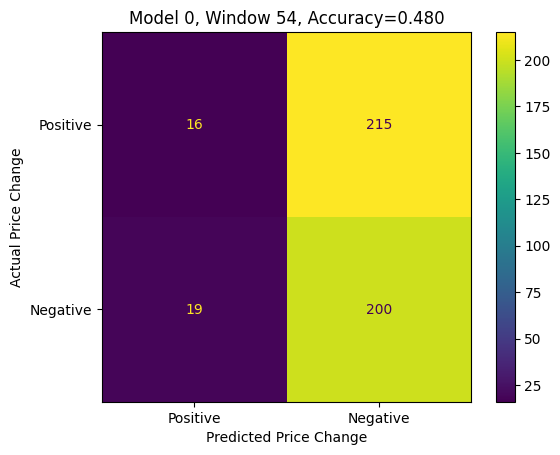

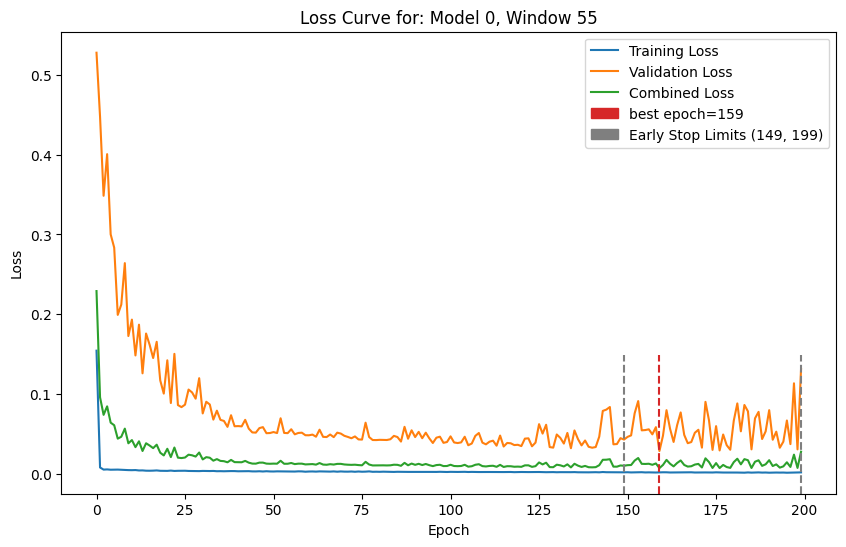

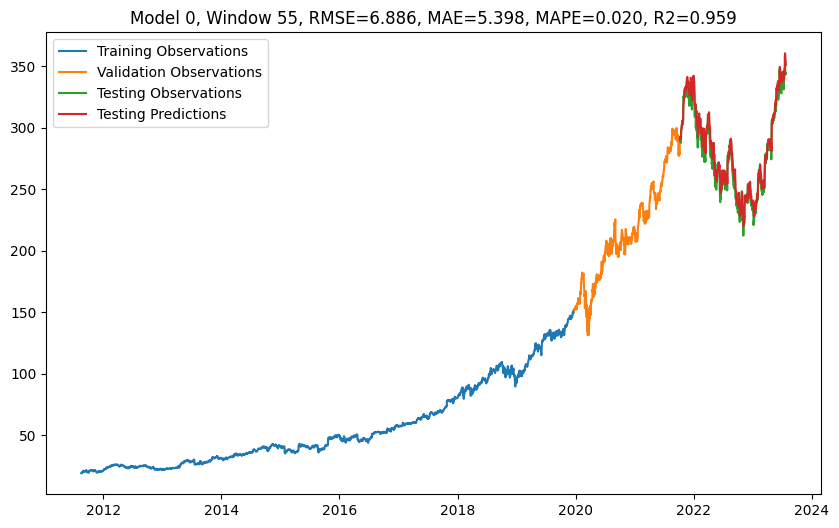

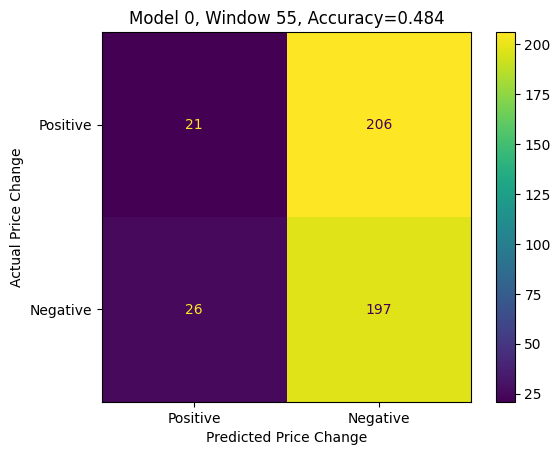

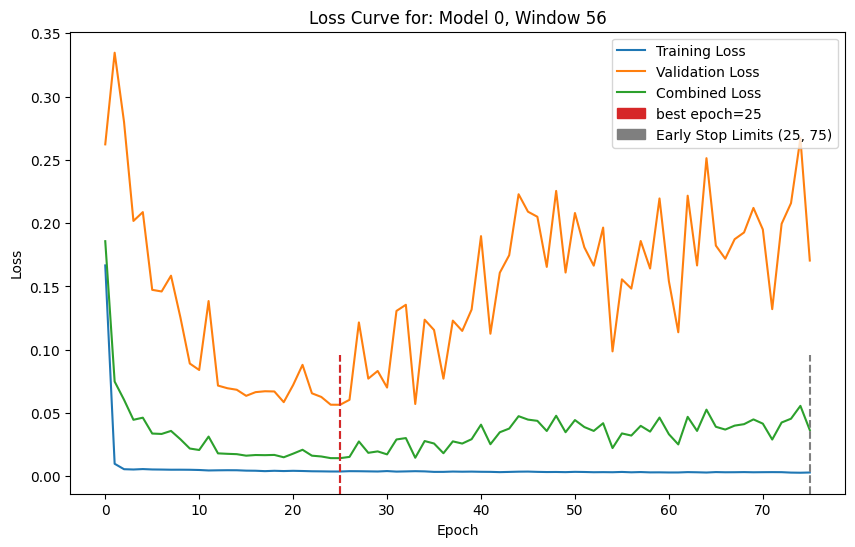

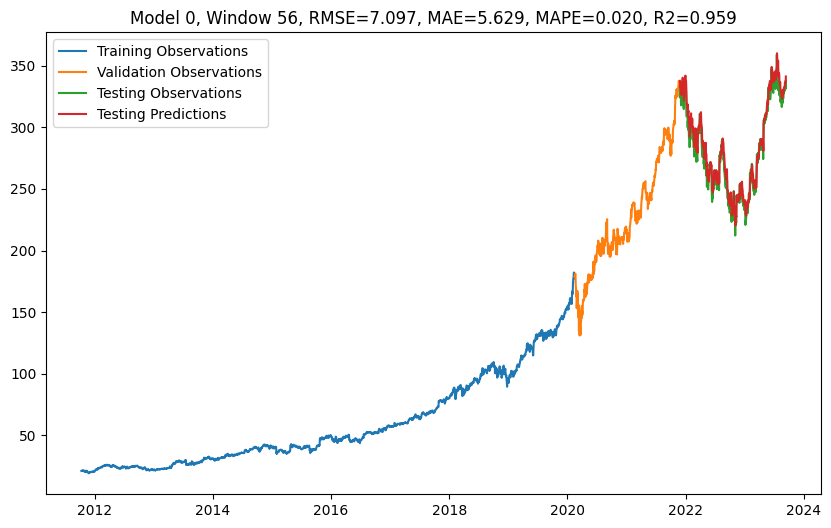

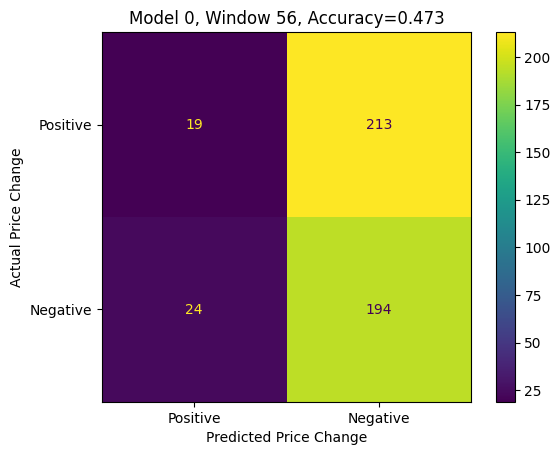

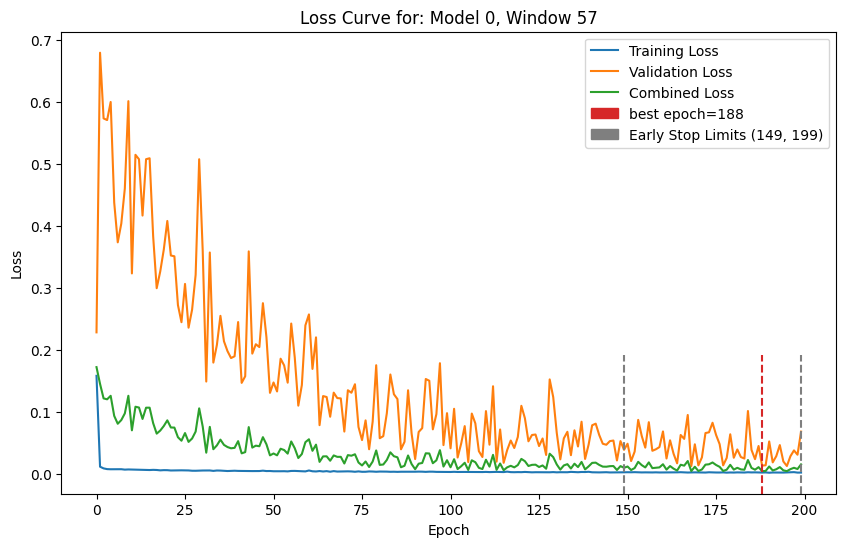

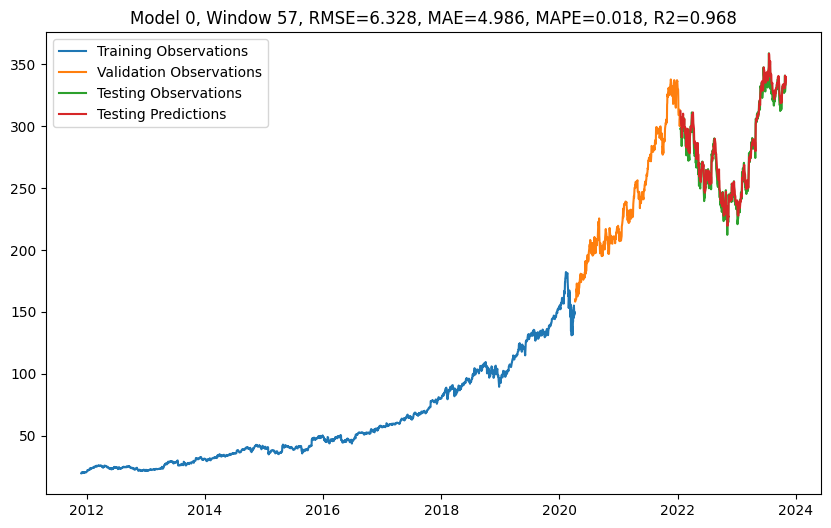

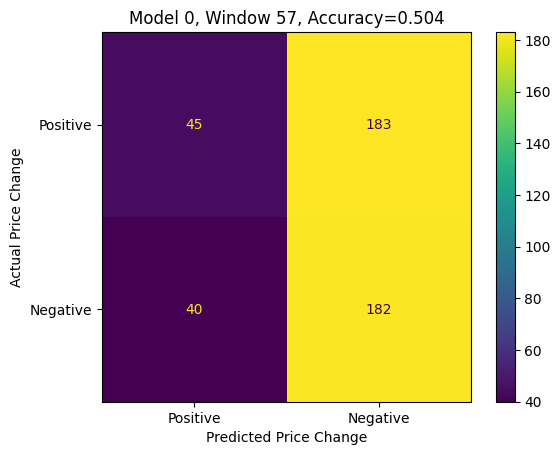

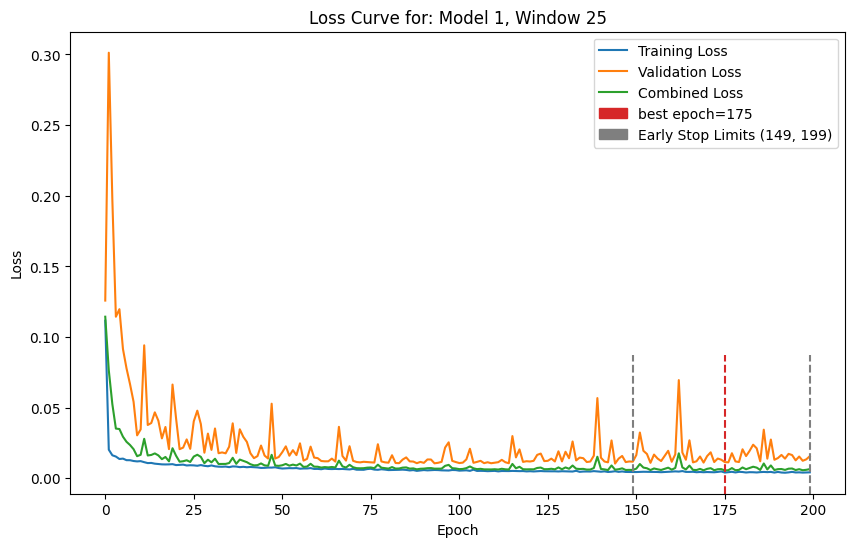

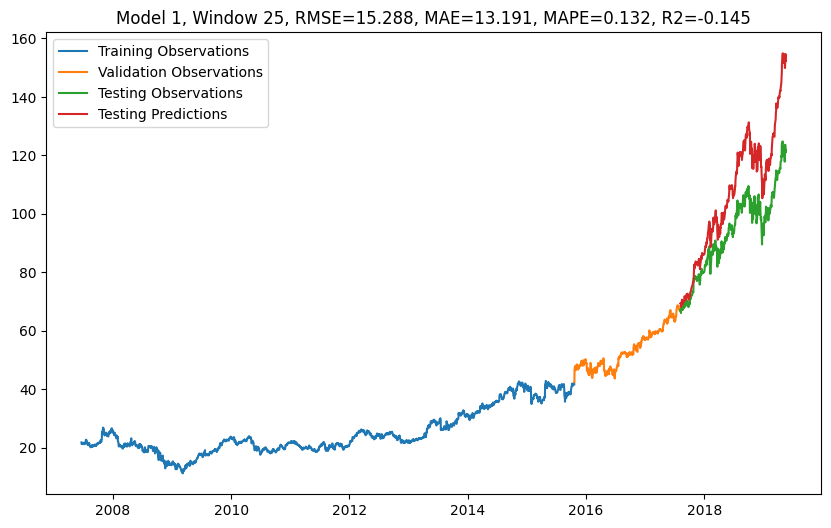

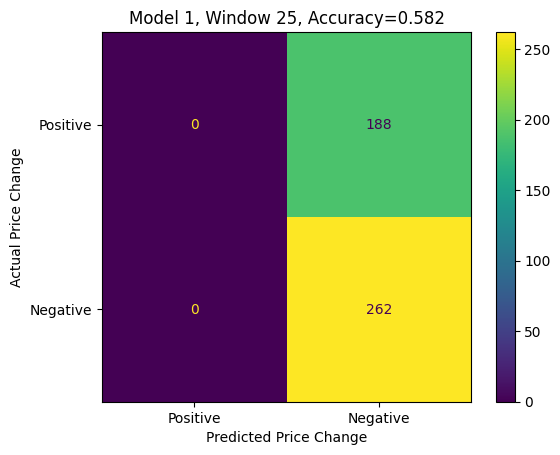

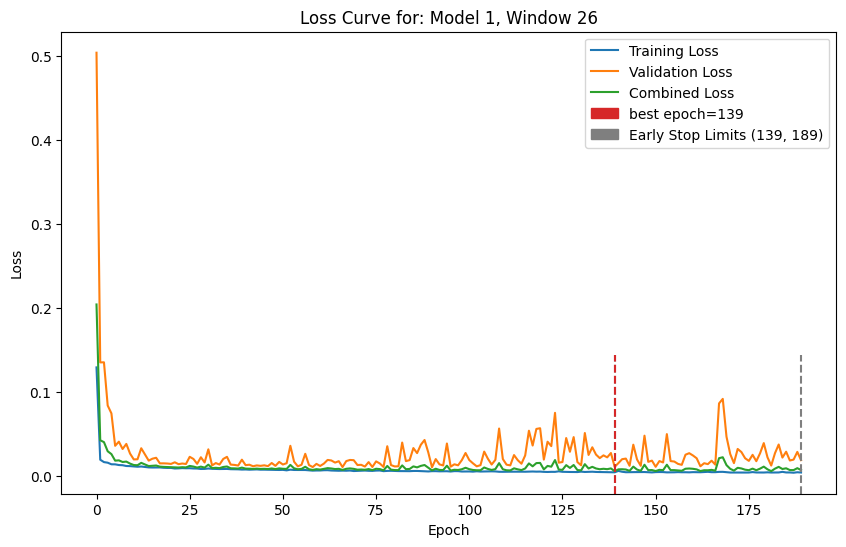

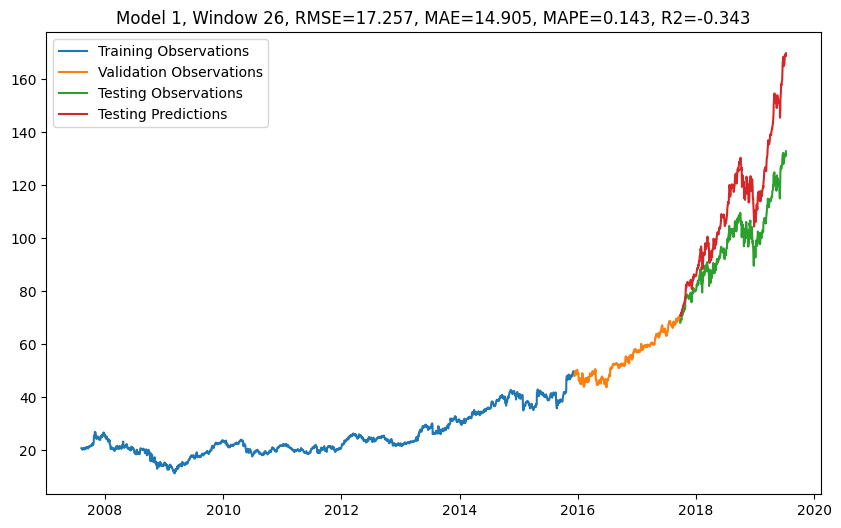

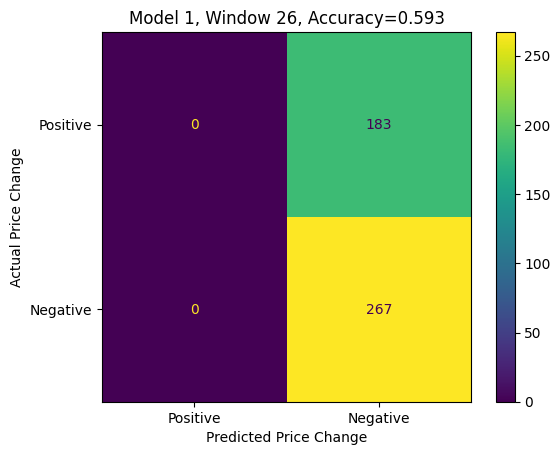

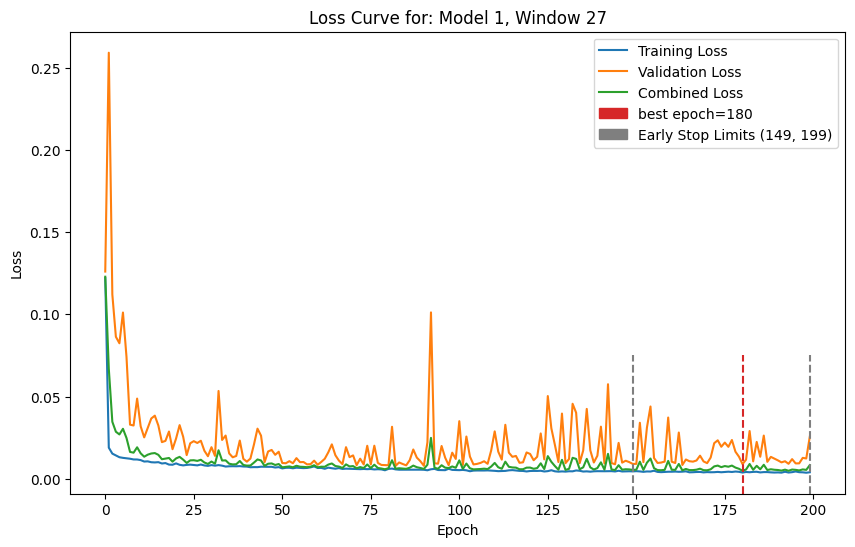

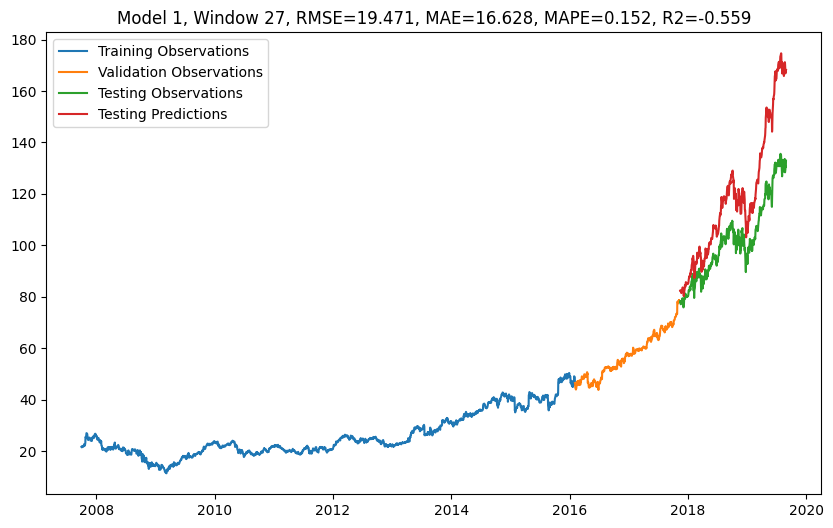

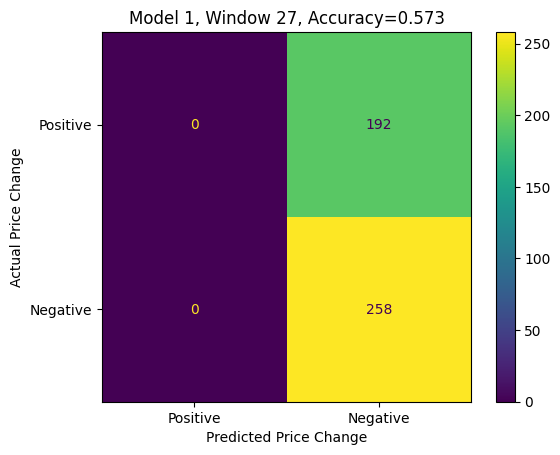

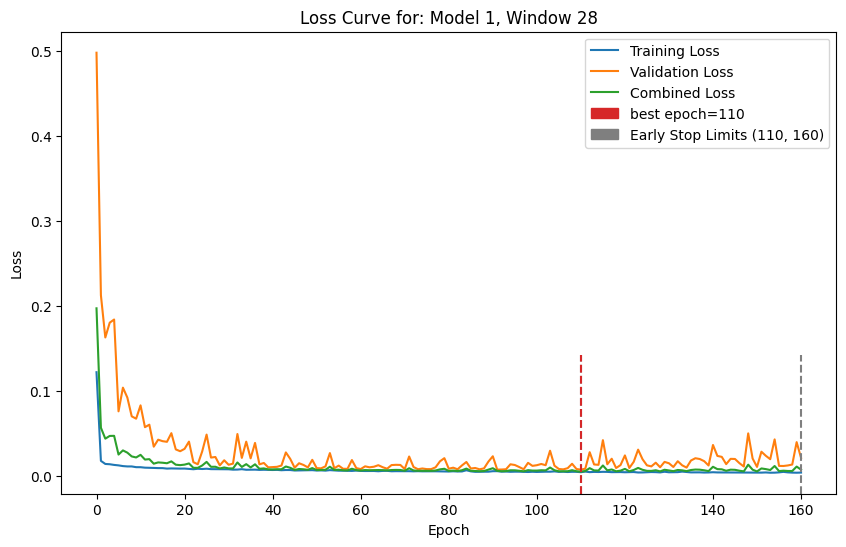

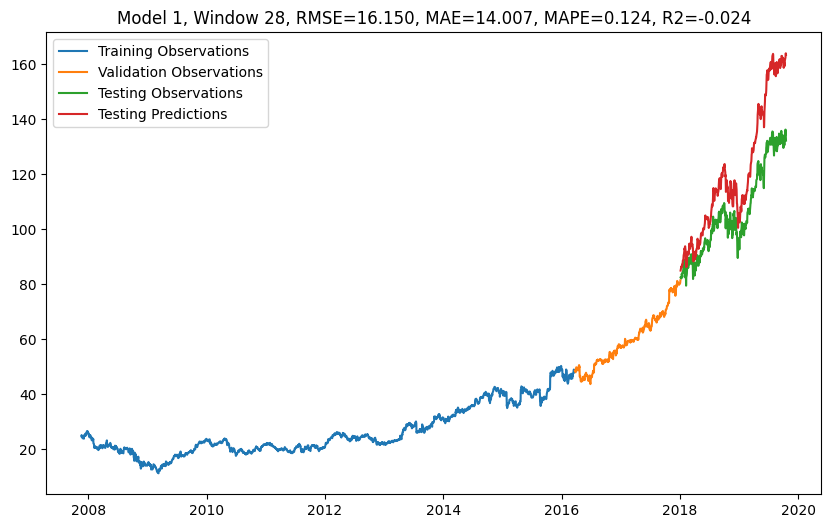

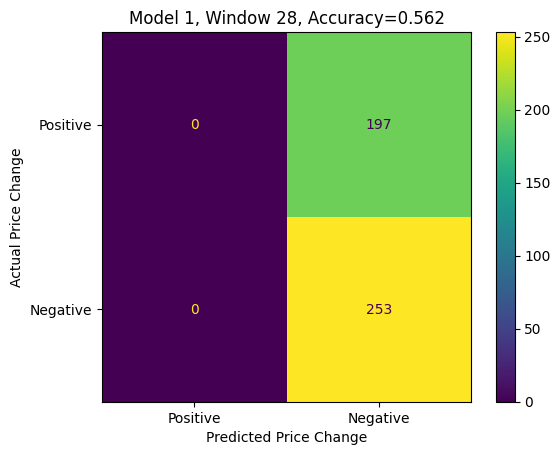

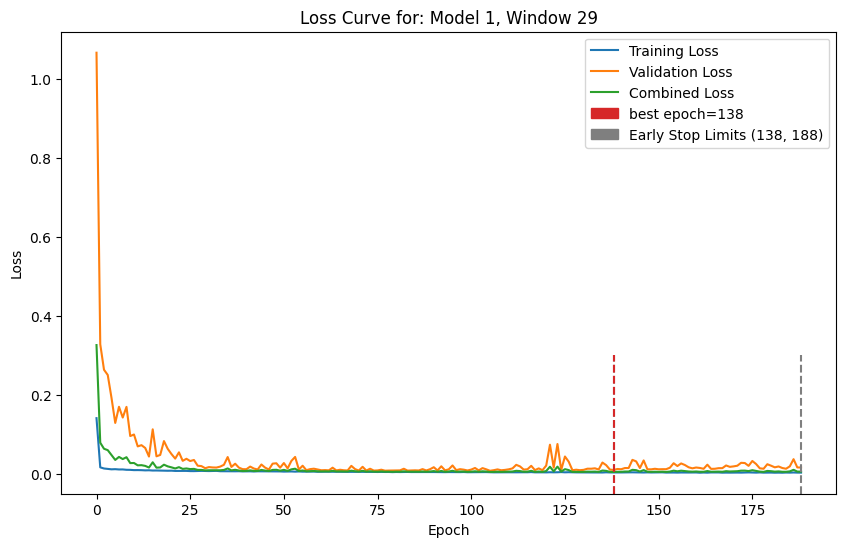

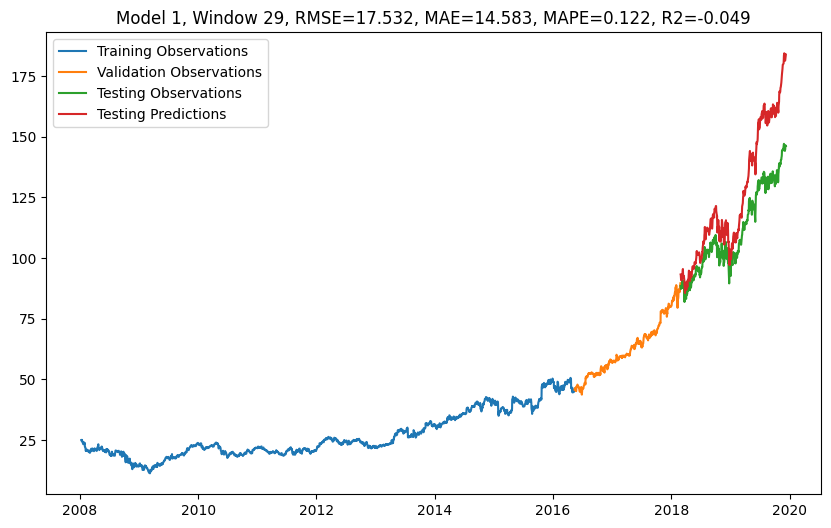

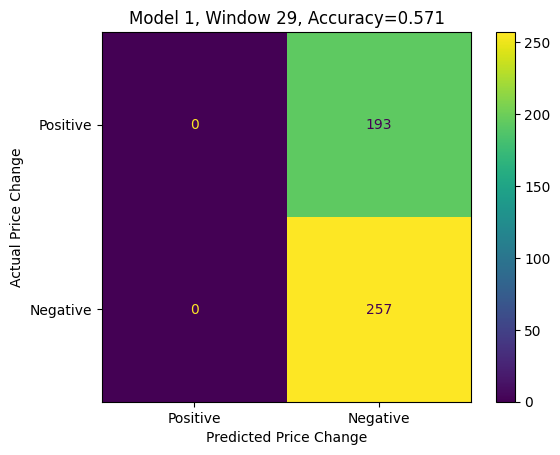

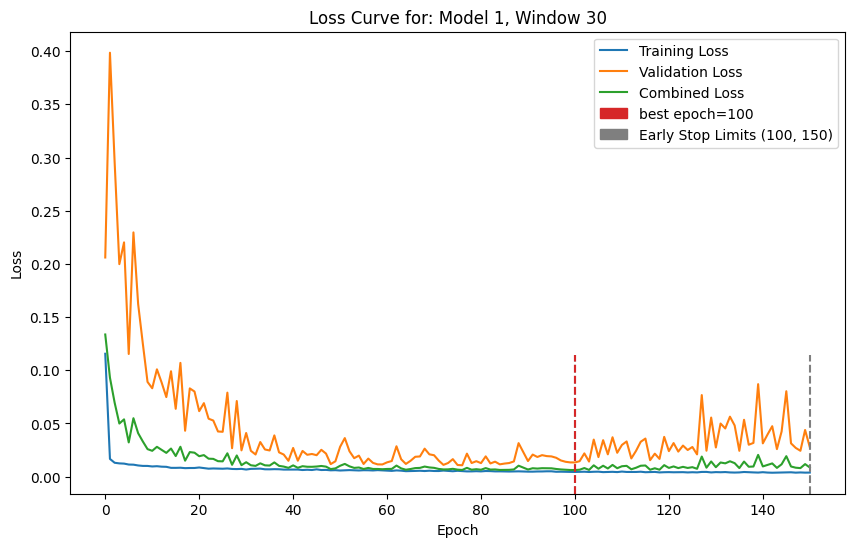

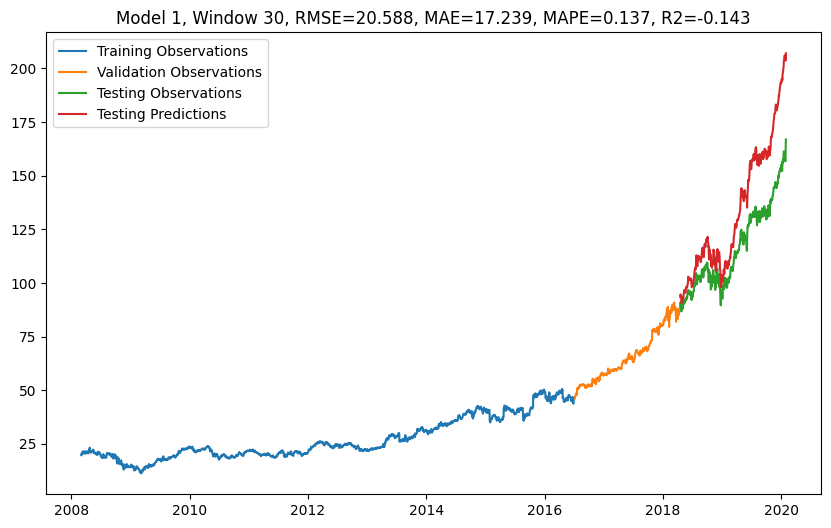

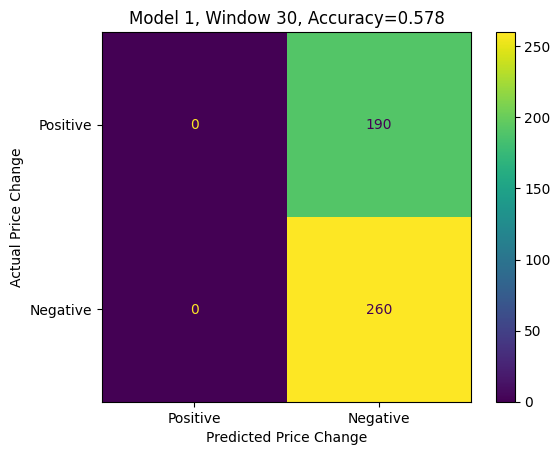

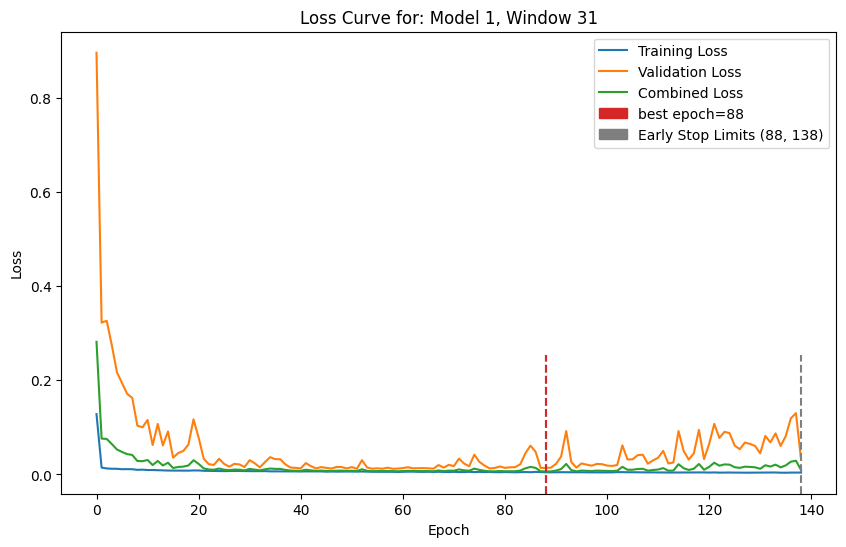

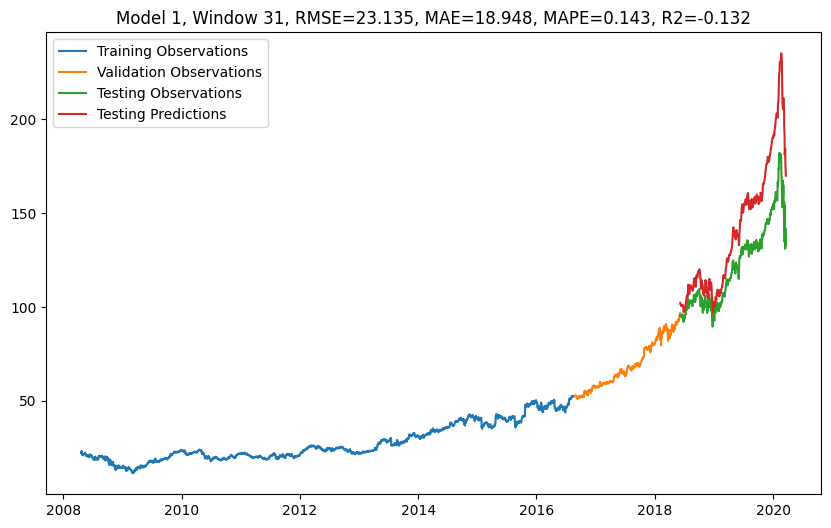

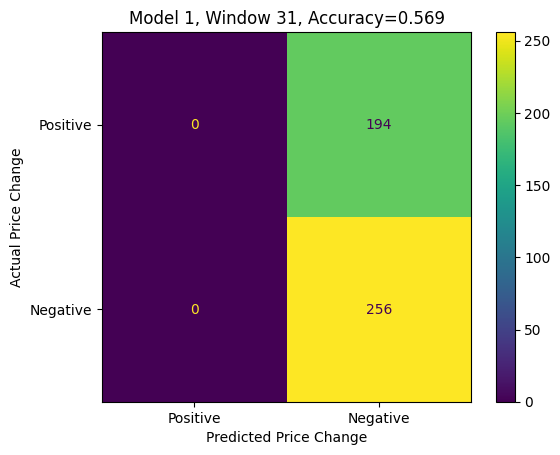

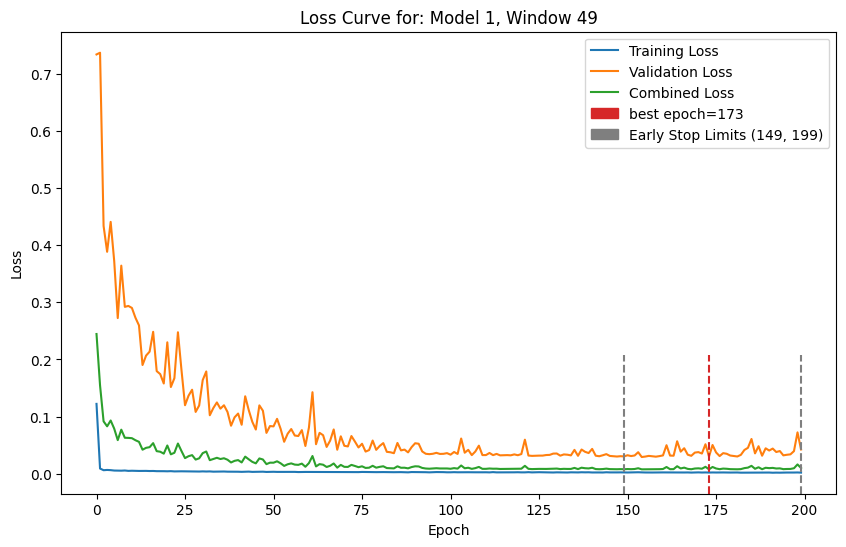

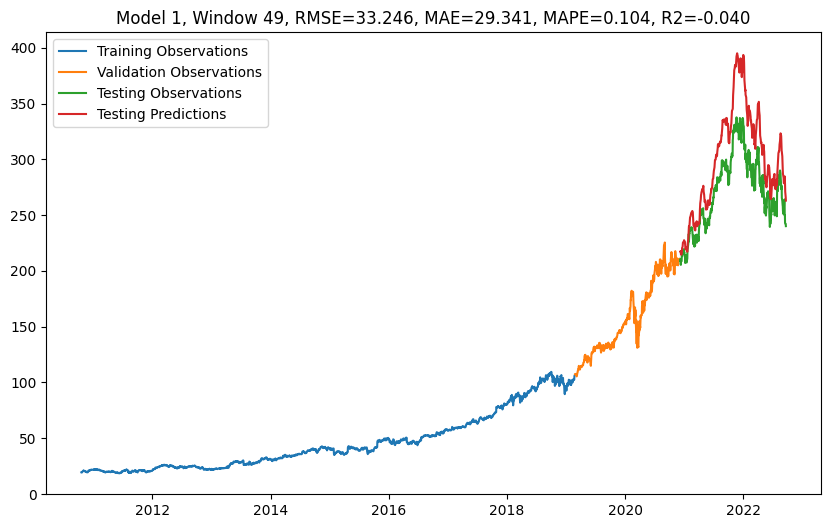

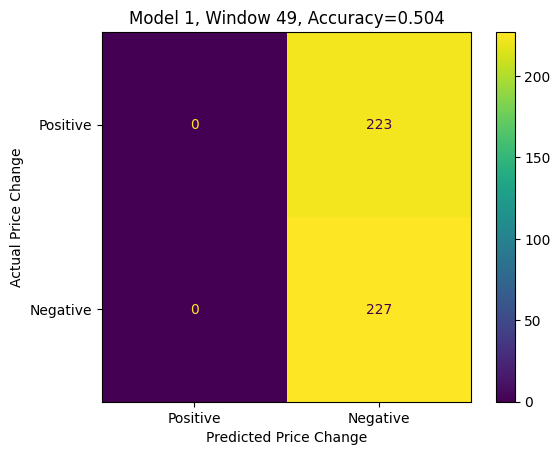

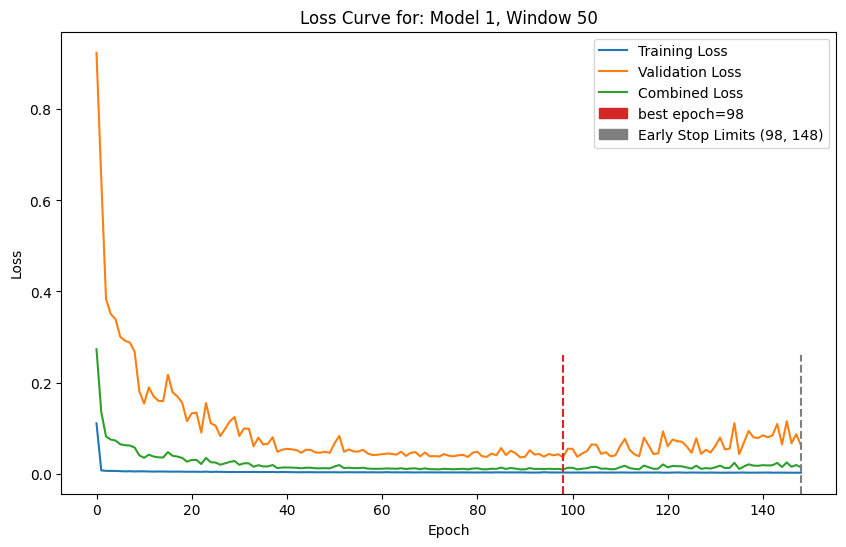

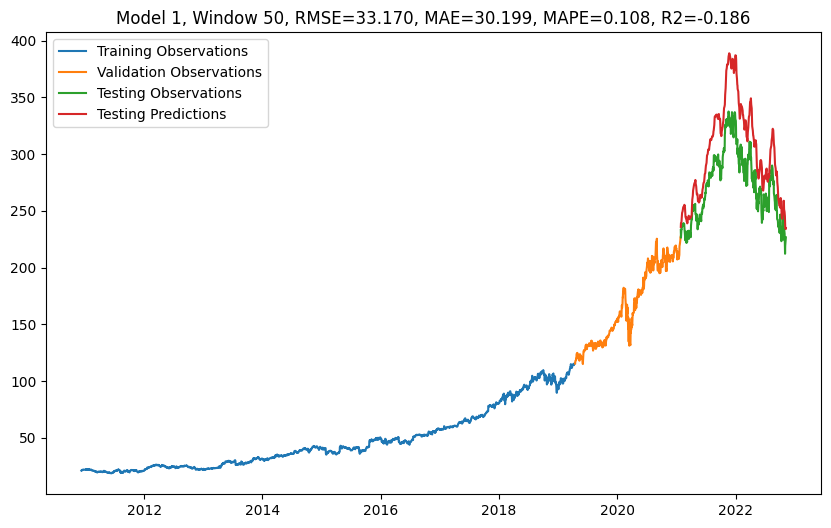

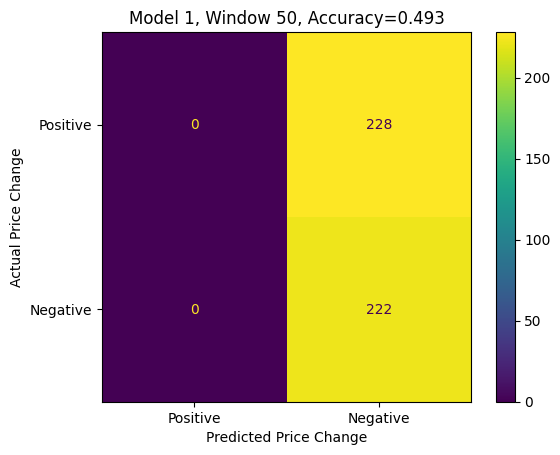

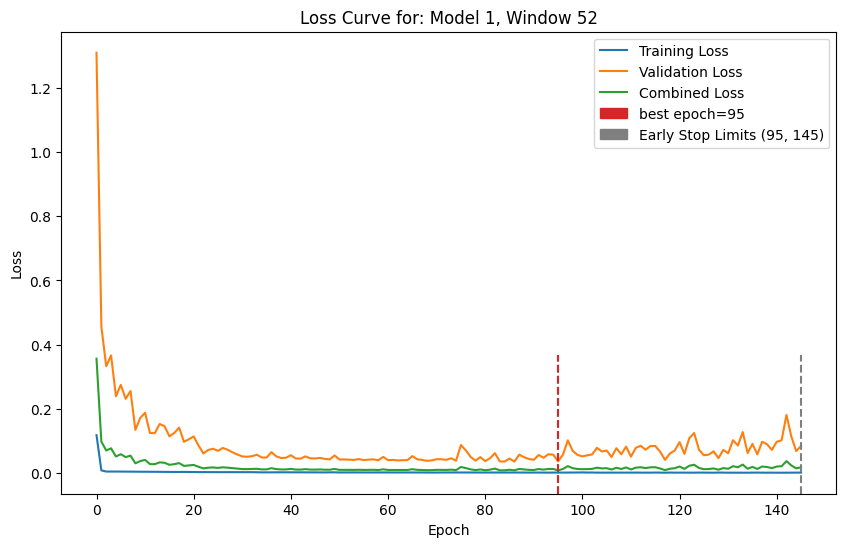

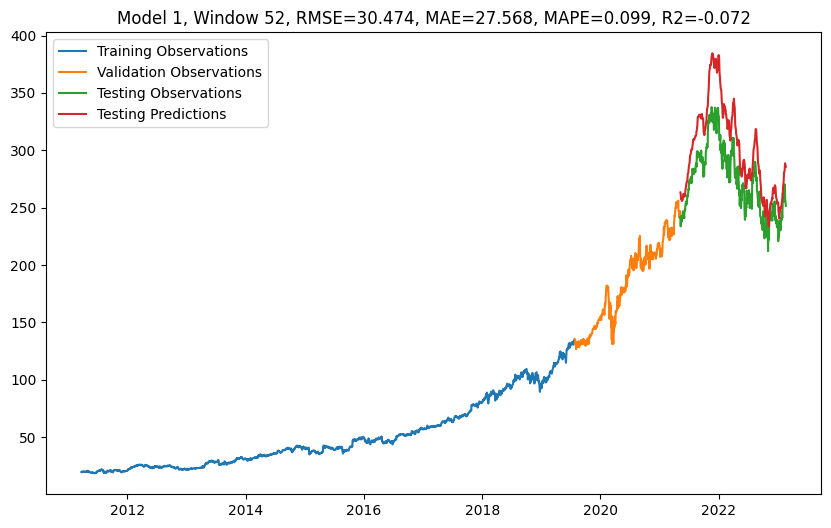

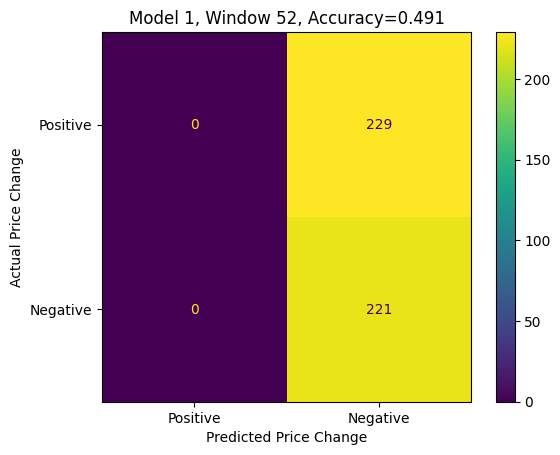

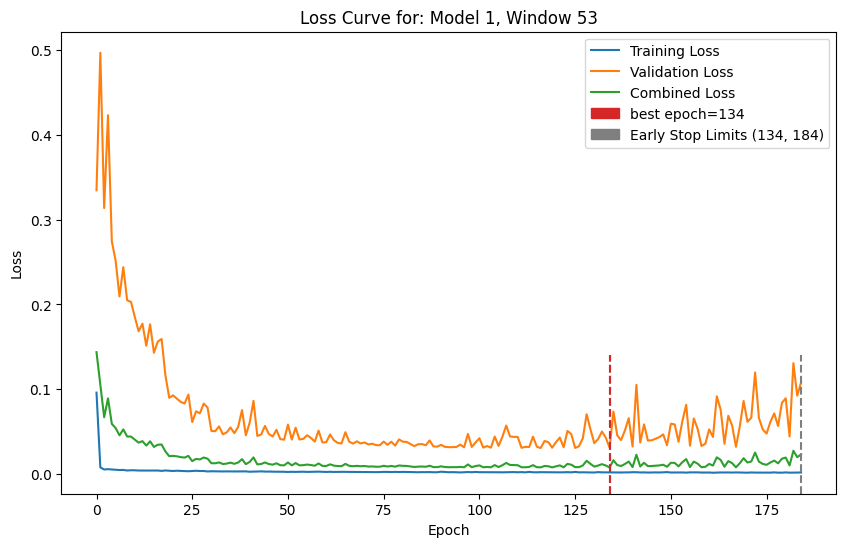

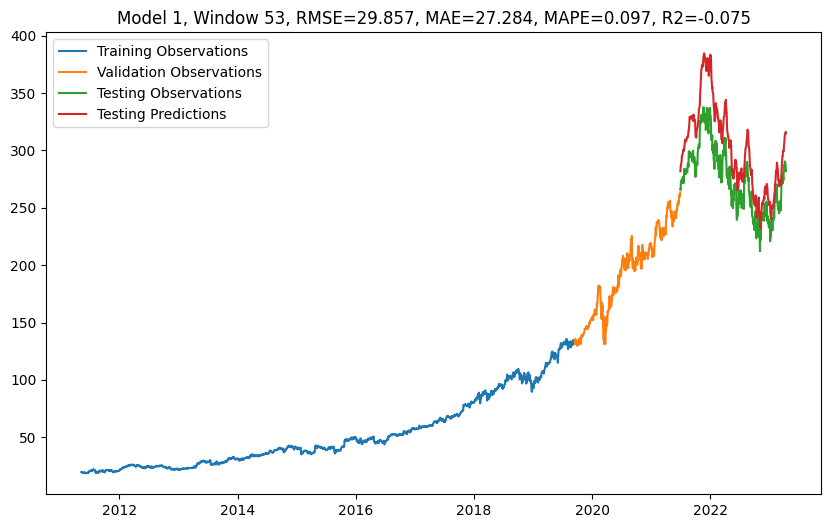

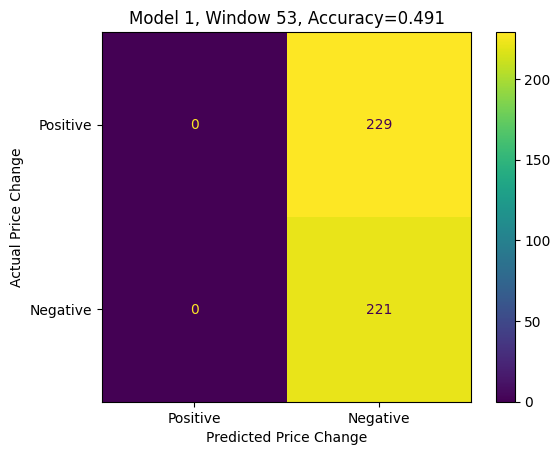

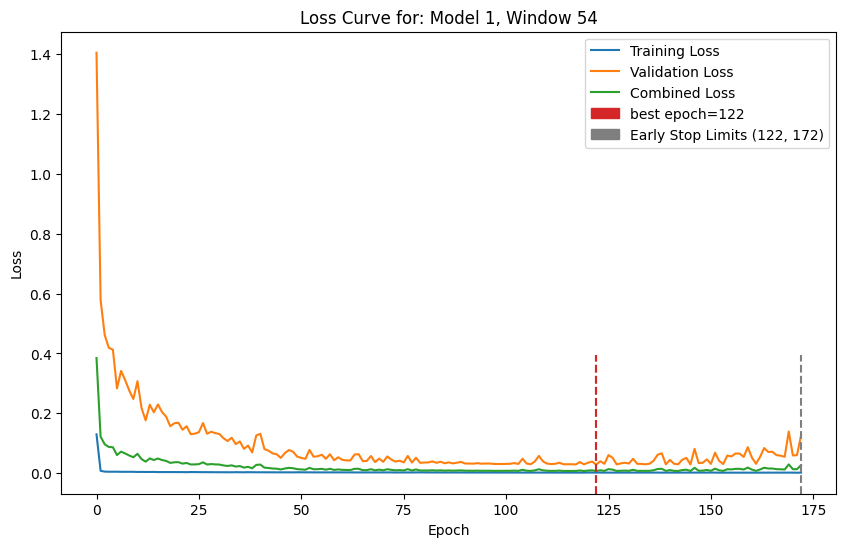

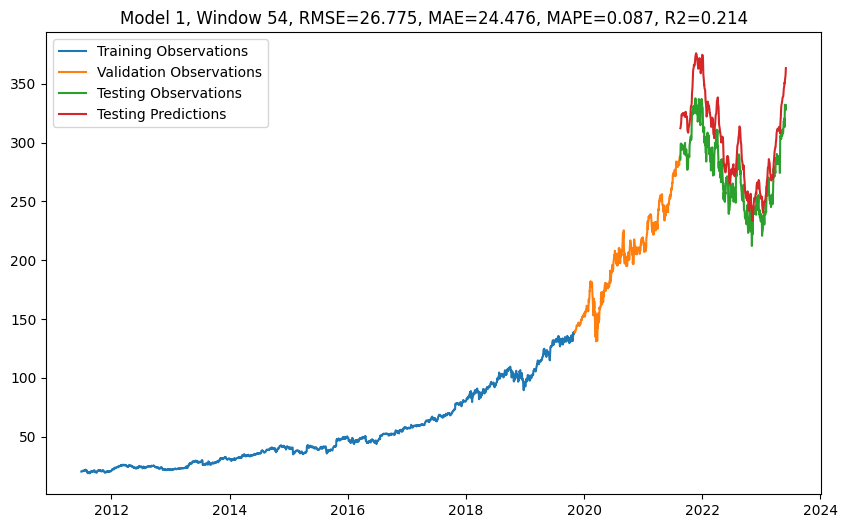

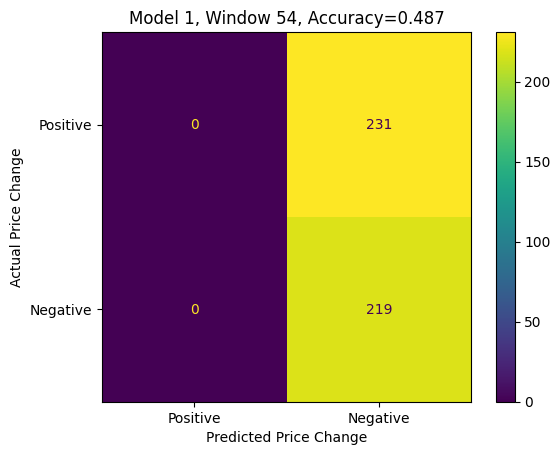

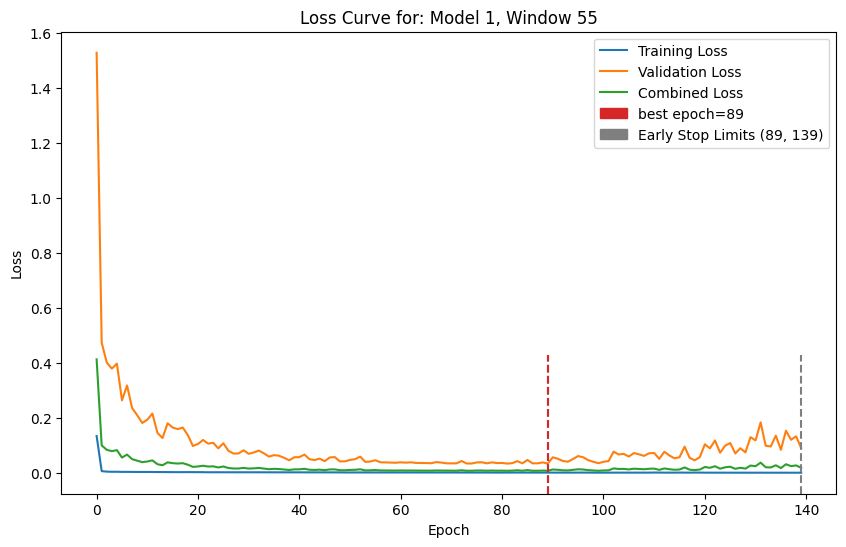

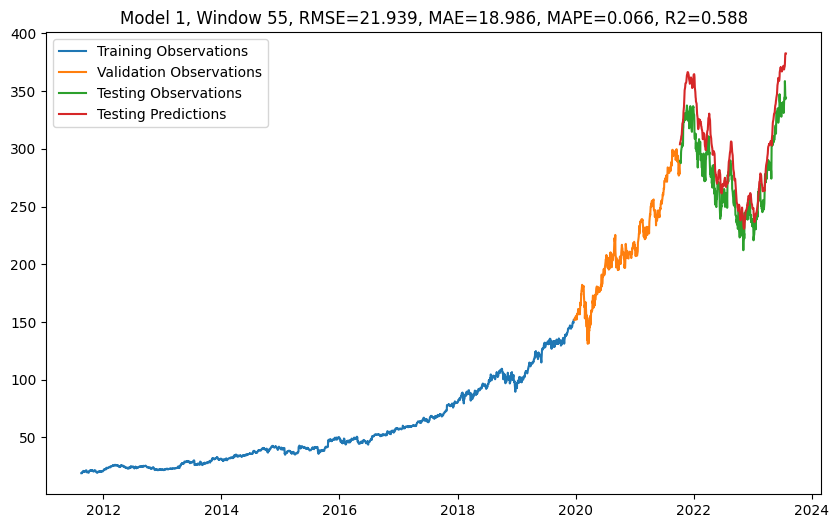

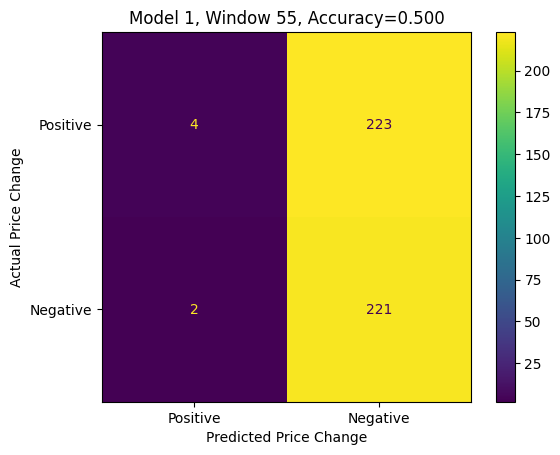

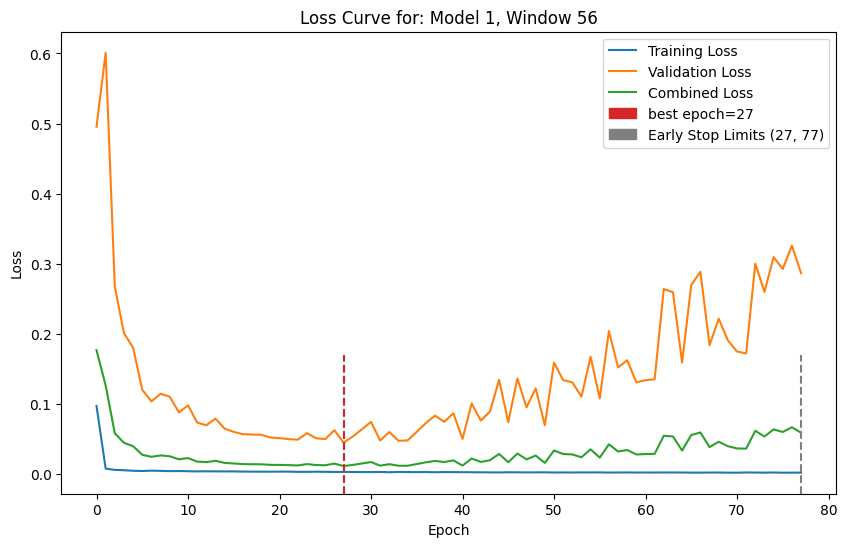

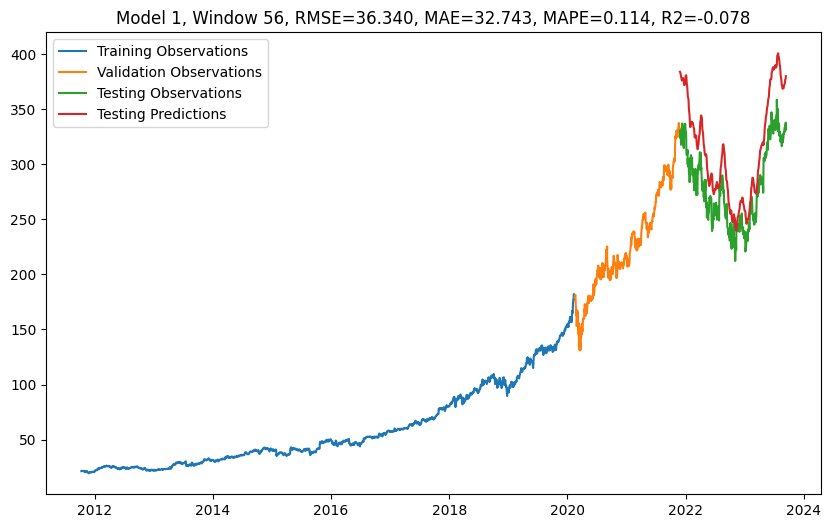

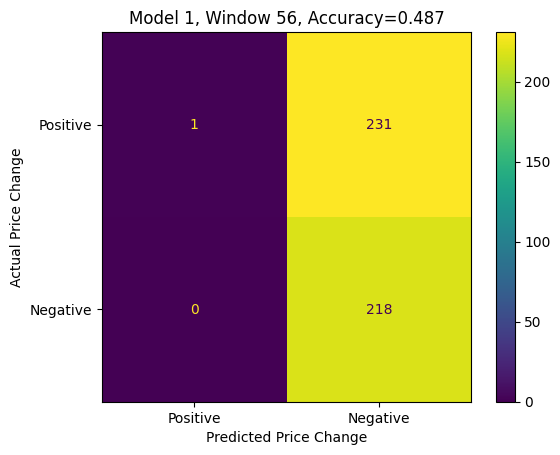

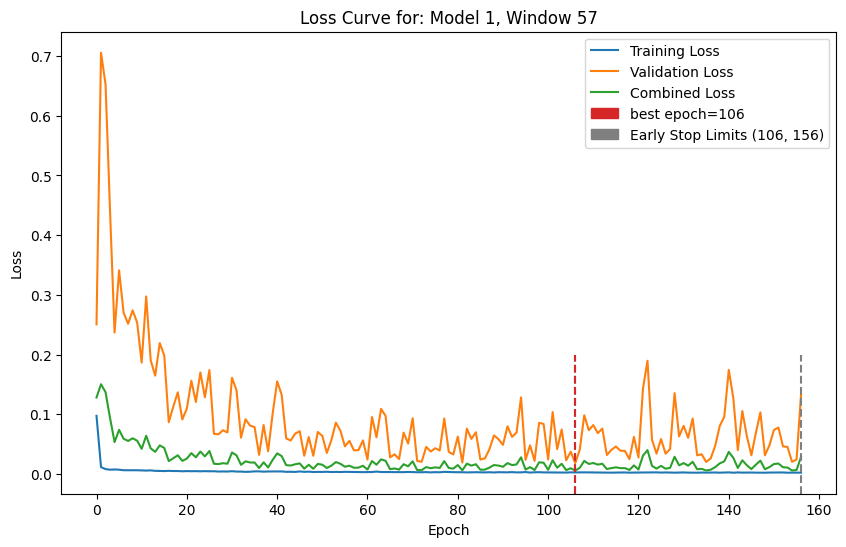

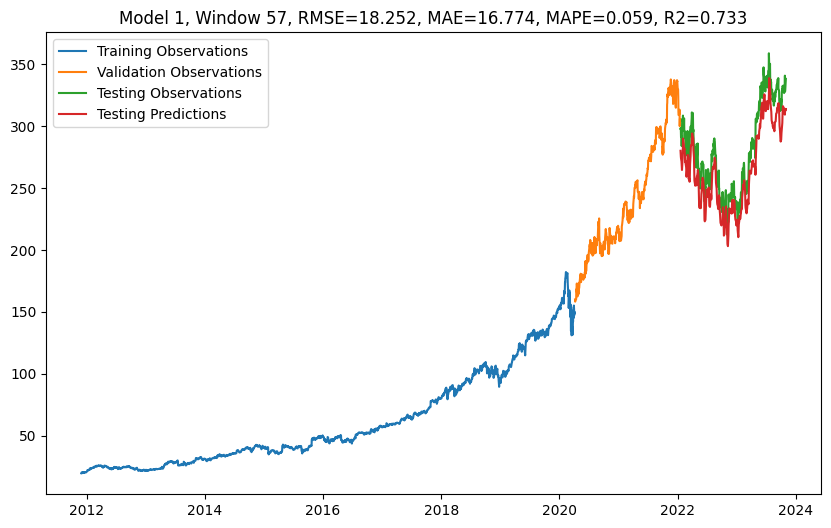

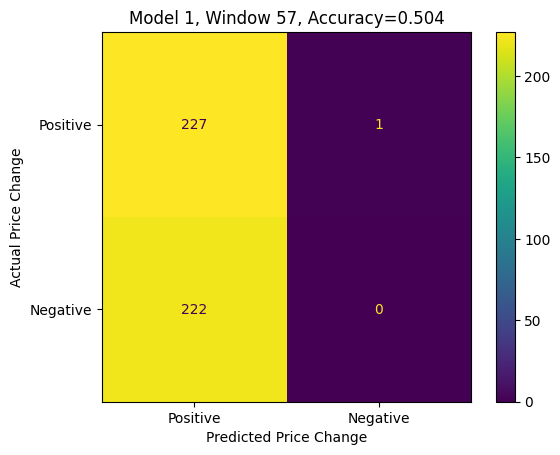

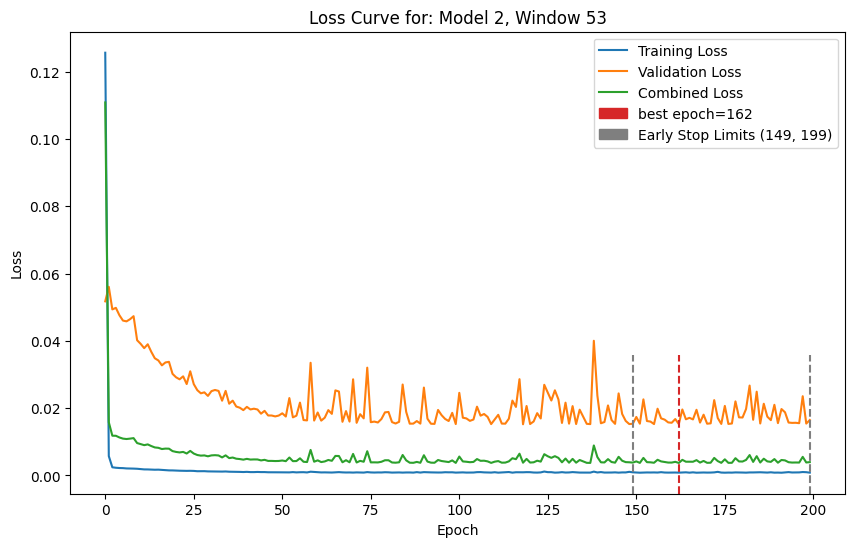

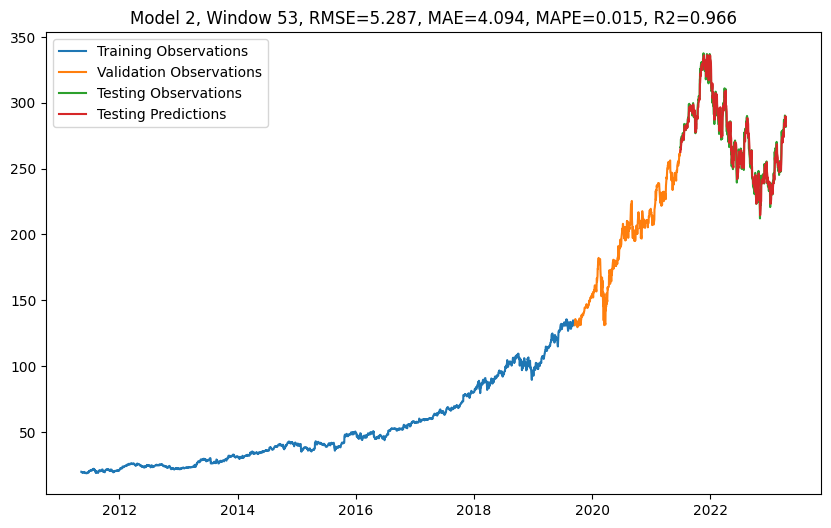

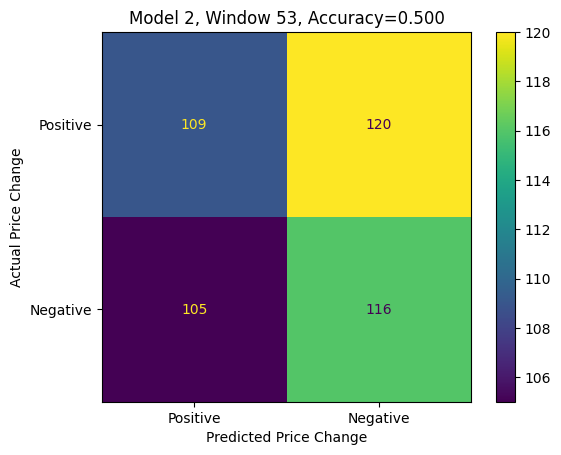

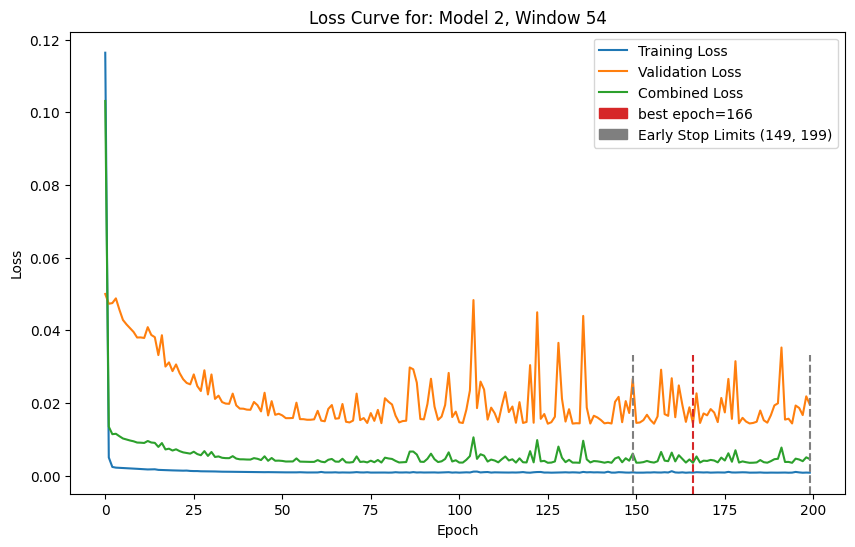

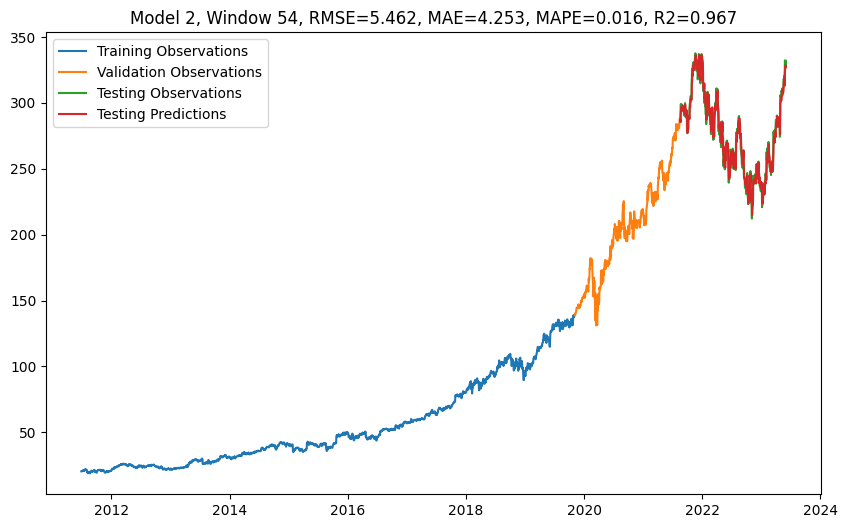

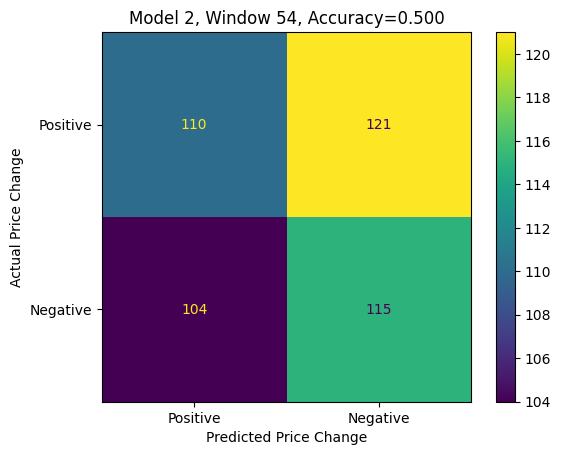

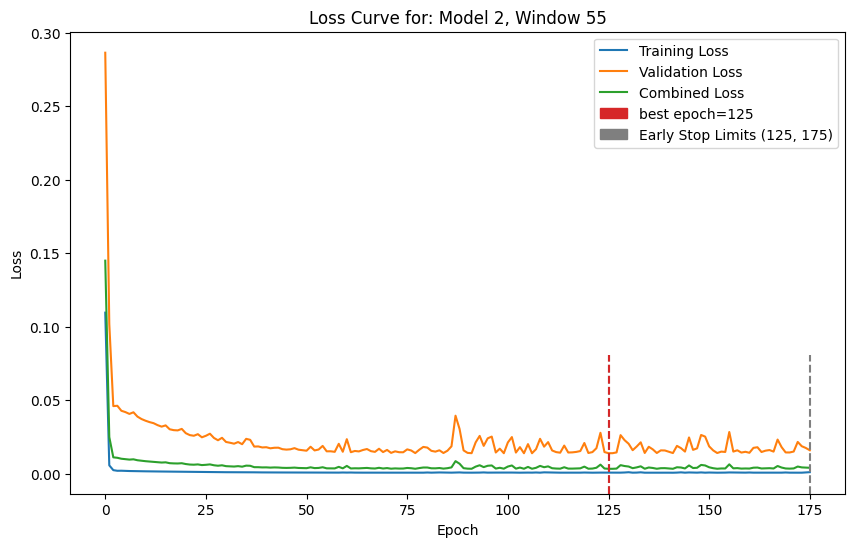

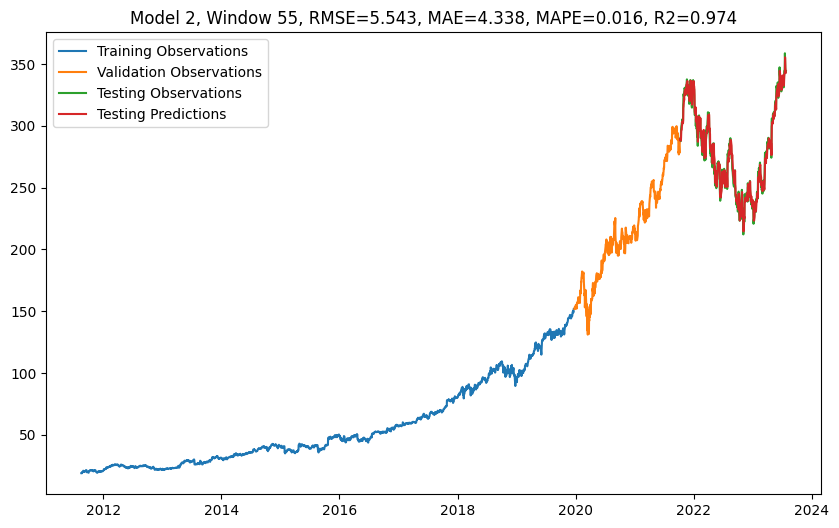

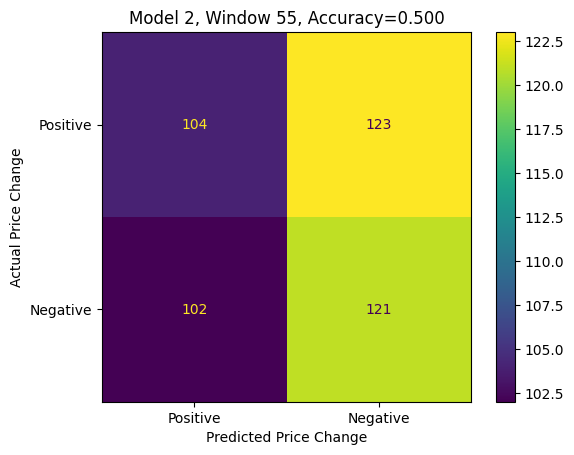

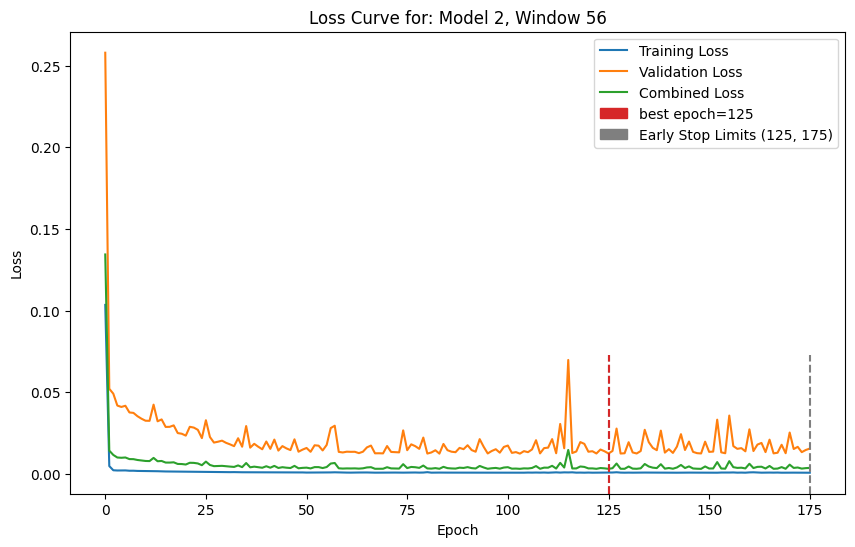

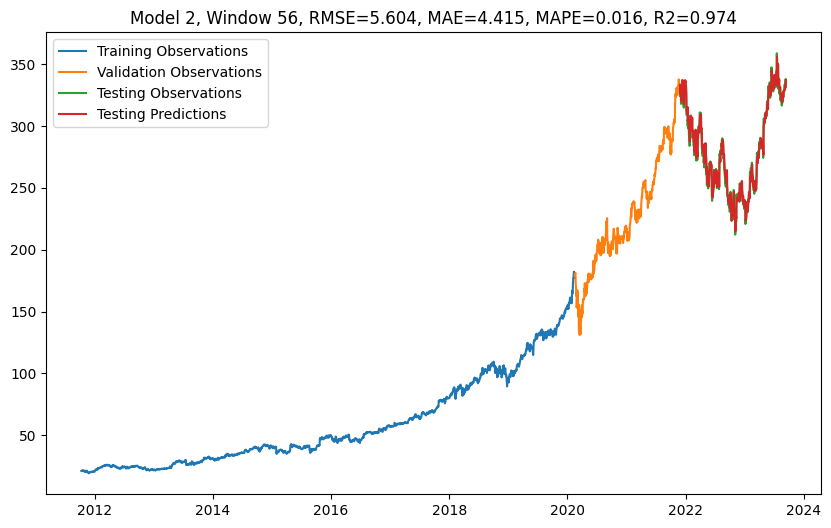

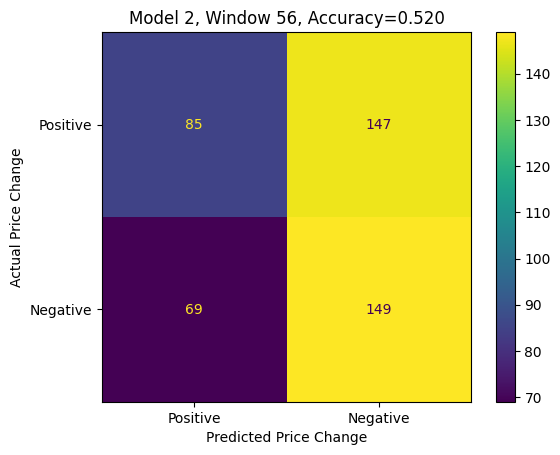

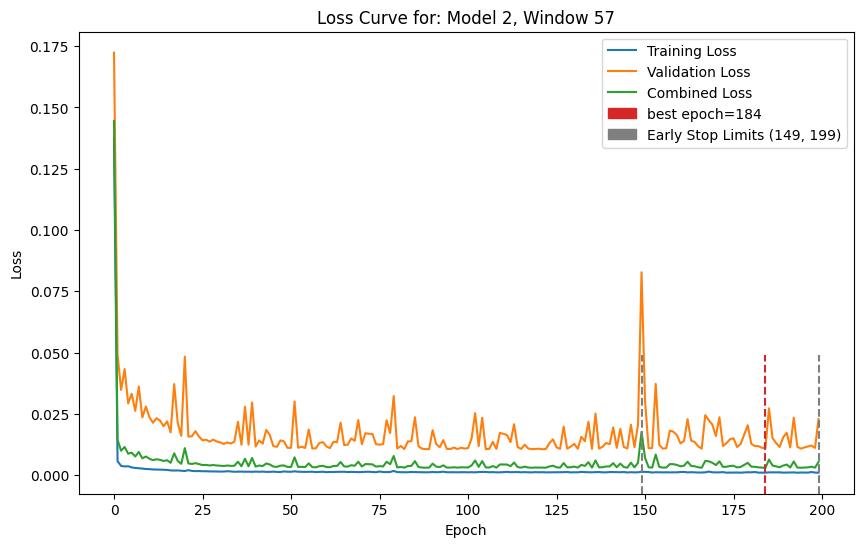

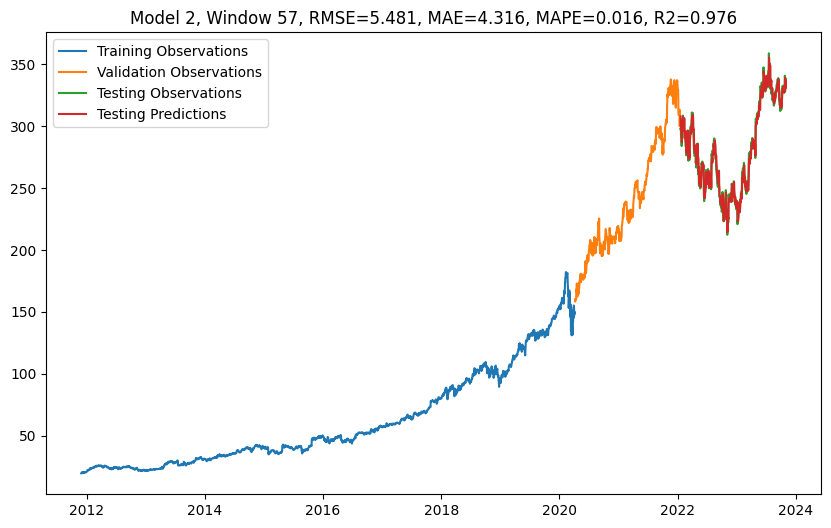

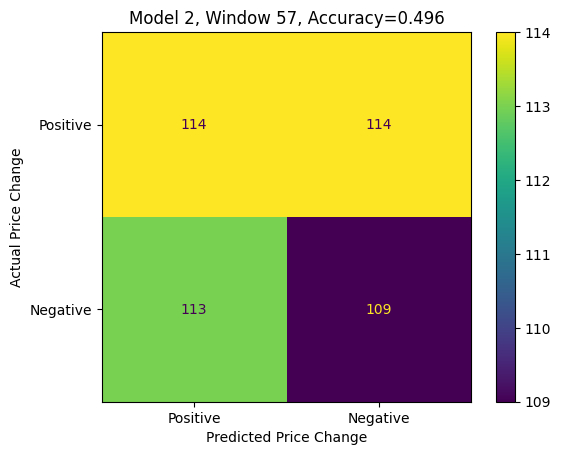

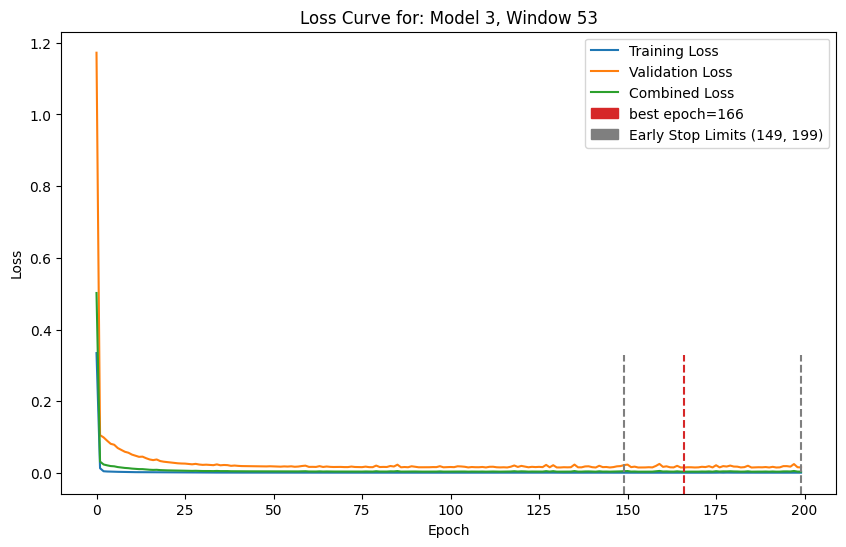

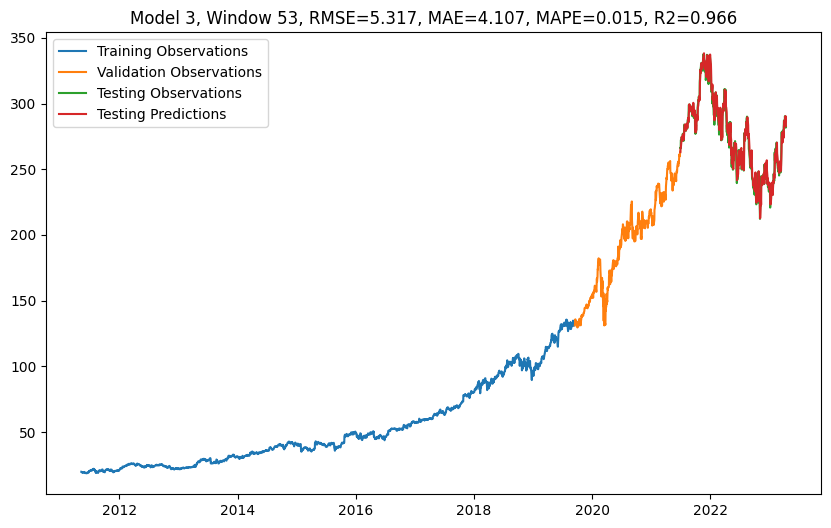

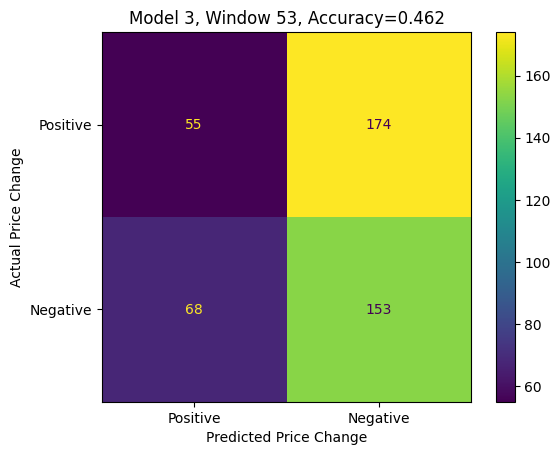

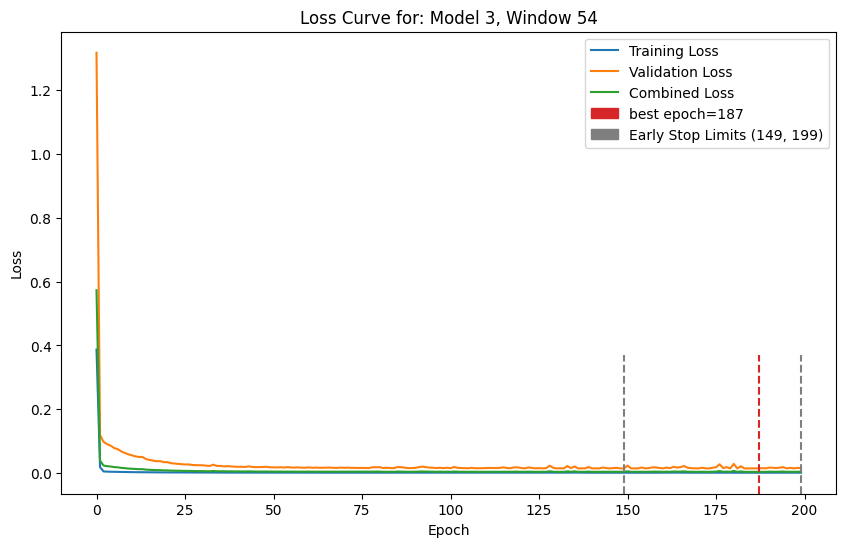

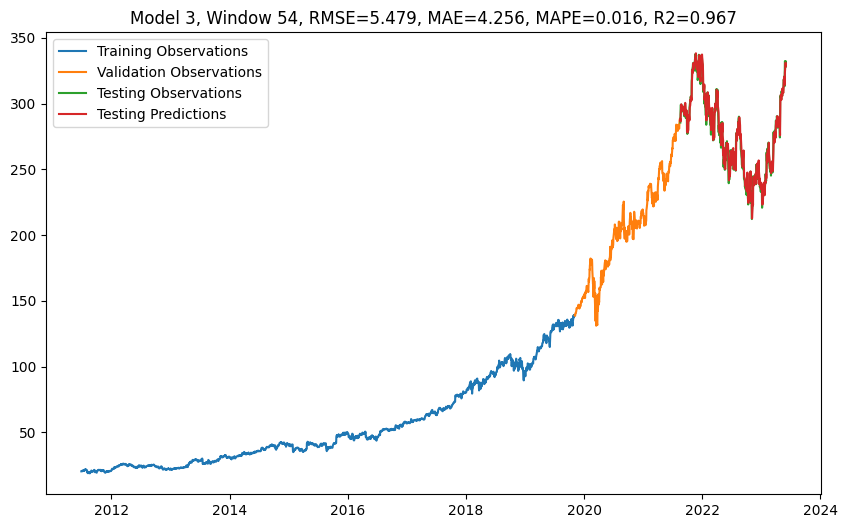

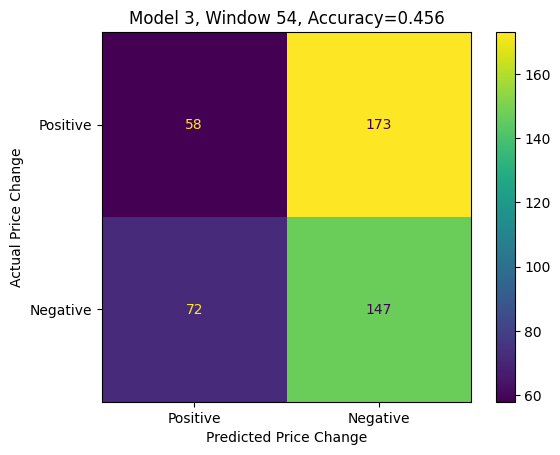

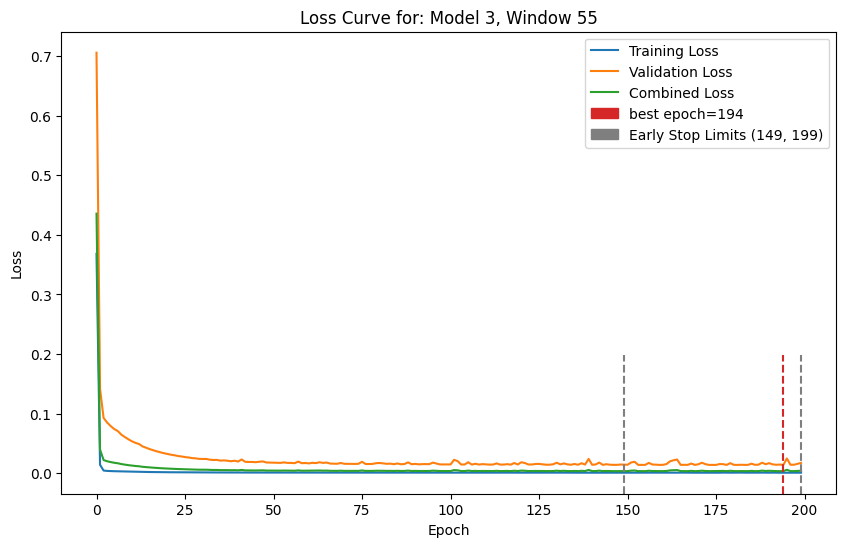

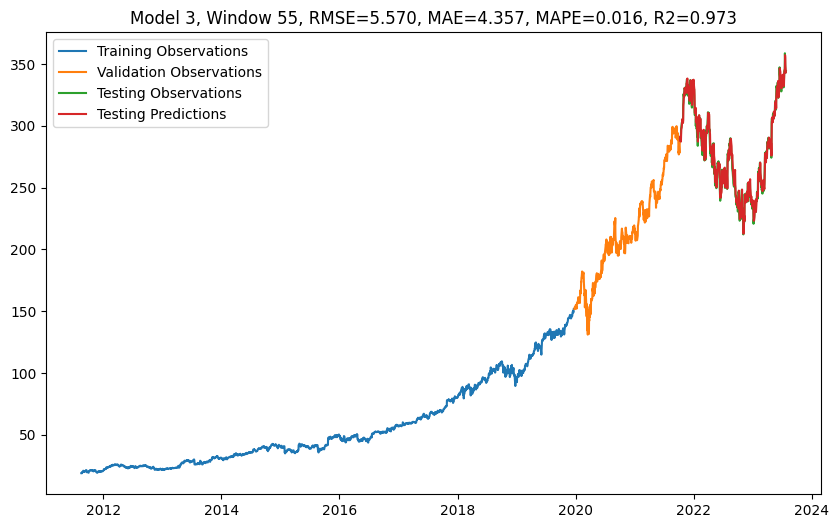

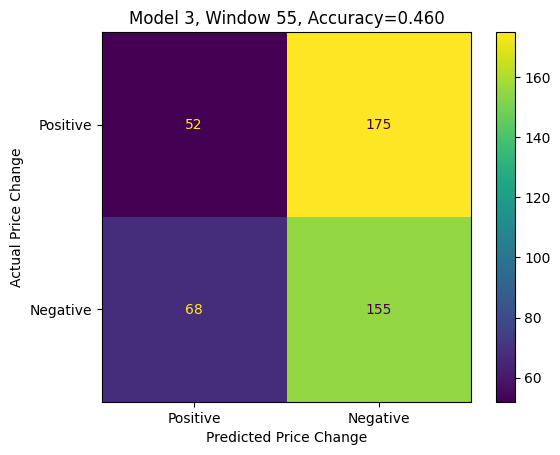

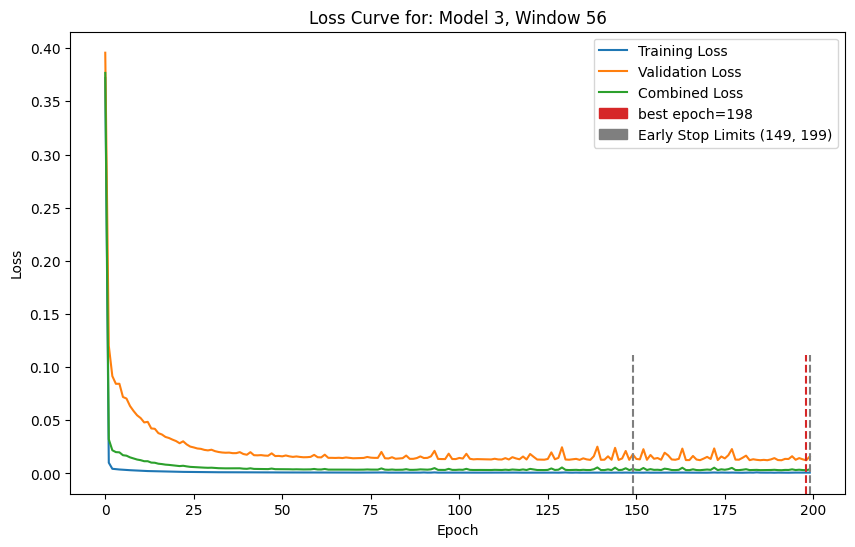

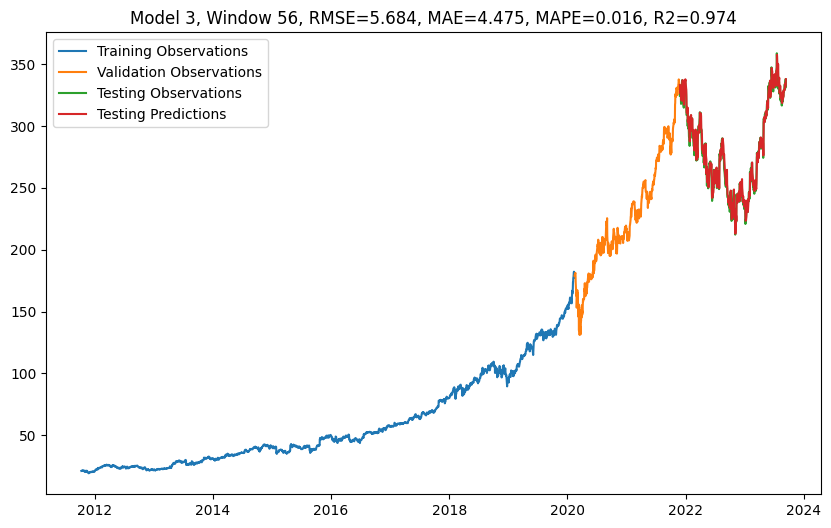

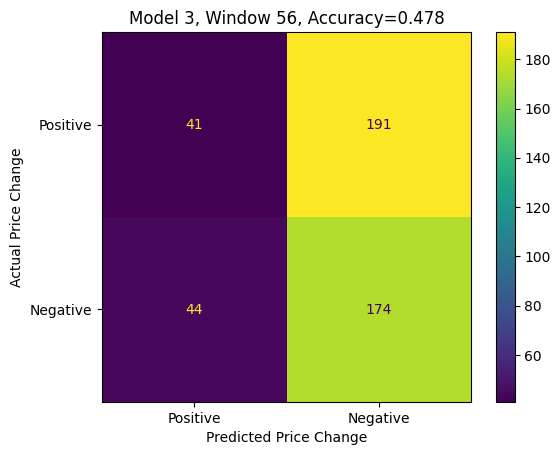

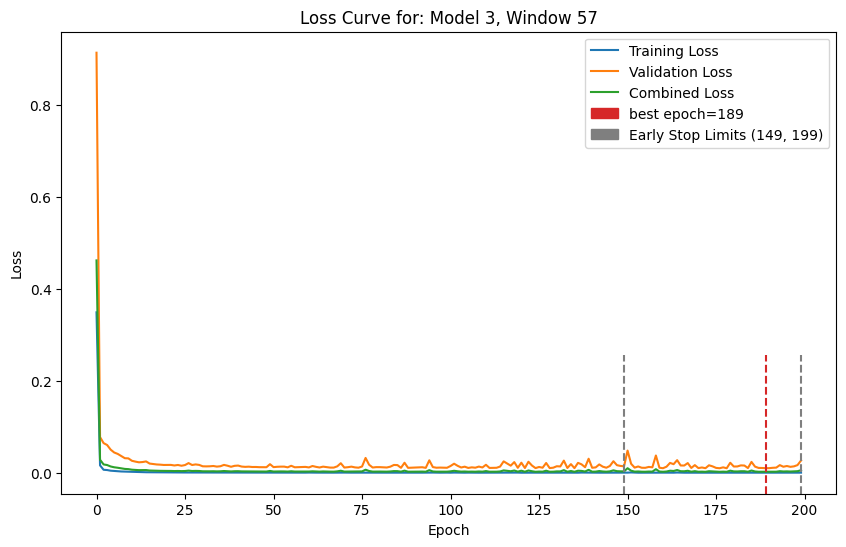

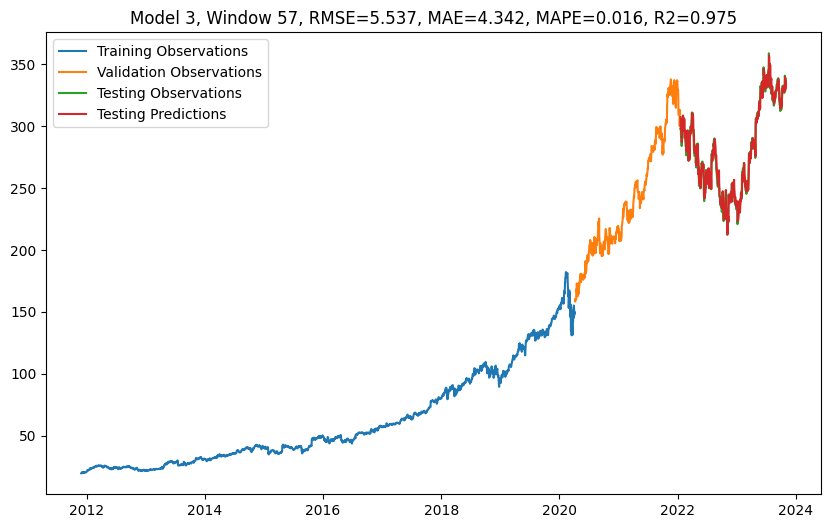

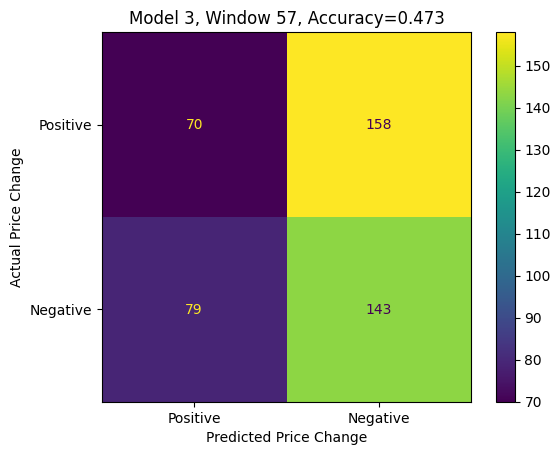

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error

def cross_validation(model, generator, model_idx, flag_plot=0):
    """
    Performs Cross validation for all models and all sliding windows;
    Calculates the cross validation score ("RMSE", "MAE", "MAPE", "R2", "Accuracy");
    Accuracy is computed by considering if the relative price change for day i was positive or negative
    """

    cv_score = pd.DataFrame(columns=["RMSE", "MAE", "MAPE", "R2", "Acc"])

    for i, (train, vali, test) in enumerate(generator):

        # Get Dates = [dates_train, dates_vali, dates_test]
        dates = [i.index for i in [train, vali, test]]

        # Get Scaled Data
        scaler = StandardScaler()
        X_train_sc, y_train_sc = split_xy(scaler.fit_transform(train))
        X_vali_sc, y_vali_sc = split_xy(scaler.transform(vali))
        X_test_sc, y_test_sc = split_xy(scaler.transform(test))

        # Fit, save best model and Predict
        model.load_weights("empty_model.h5", skip_mismatch=True, by_name=True)
        model.reset_states()
        history = model.fit(
            X_train_sc, y_train_sc,
            validation_data=(X_vali_sc, y_vali_sc),
            epochs=200, # maximum number of epochs
            batch_size=64, # better for jumping local minimas
            verbose=False,
            callbacks=[combined_cb, earlyStop, model_checkpoint]
        )
        model.load_weights("tmp_best_model.h5", skip_mismatch=True, by_name=True)
        preds_sc = model.predict(X_test_sc, verbose=False)

        # Get Non-Scaled Data
        X_train, y_train = split_xy(train.to_numpy())
        X_vali, y_vali = split_xy(vali.to_numpy())
        X_test, y_test = split_xy(test.to_numpy())
        X_result, y_result = split_xy(scaler.inverse_transform(np.hstack((X_test_sc, preds_sc))))
        ys = [y_train, y_vali, y_test, y_result]

        # Compute Metrics
        rmse = mean_squared_error(y_true=y_test, y_pred=y_result, squared=False)
        mae = mean_absolute_error(y_true=y_test, y_pred=y_result)
        mape = mean_absolute_percentage_error(y_true=y_test, y_pred=y_result)
        r2 = r2_score(y_true=y_test, y_pred=y_result)
        acc, cm = compute_accuracy_and_cm(y_vali, y_test, y_result)

        metrics = [rmse, mae, mape, r2, acc]

        # Plot All Curves and Metrics; Also loss curves
        if flag_plot == 2:
            plot_loss_curve(history, model_idx, i)
            plot_predictions(dates, ys, metrics, model_idx, i)
            plot_confusion_matrix(cm, metrics, model_idx, i)

        # Plot last 5 Curves and Metrics; and bad fits, also the respective loss curves
        elif (flag_plot == 1 and ((i >= (windows_cnt - 5)) or (r2 < 0) )):
            plot_loss_curve(history, model_idx, i)
            plot_predictions(dates, ys, metrics, model_idx, i)
            plot_confusion_matrix(cm, metrics, model_idx, i)

        # Append Result
        cv_score.loc[len(cv_score)] = metrics

    return cv_score


# For each model, perform a cross validation training,
# plot graphs and compute metrics if wanted
cv_scores = []
for i, model in enumerate(models):
    model.compile(
        loss="mean_squared_error",
        optimizer=Adam(learning_rate=0.0001)
    )
    model.save_weights("empty_model.h5")
    generator = sliding_window_generator(windowed_df)
    cv_score = cross_validation(model, generator, i, 1)
    cv_scores.append(cv_score)

## Results

In [ ]:
# Output summary (mean, std, min, max)
for i, cv_score in enumerate(cv_scores):
    print(f"Model {i}")
    print(cv_score.describe(), "\n\n")

Model 0
            RMSE        MAE       MAPE         R2        Acc
count  58.000000  58.000000  58.000000  58.000000  58.000000
mean    6.289046   5.063464   0.032982   0.905760   0.539732
std     5.305969   4.421228   0.021660   0.084164   0.030515
min     0.690950   0.499402   0.008601   0.700304   0.473333
25%     1.321925   1.053962   0.019697   0.822584   0.516667
50%     6.903530   5.446026   0.023803   0.934091   0.543333
75%     8.047154   6.556716   0.052888   0.966958   0.563889
max    19.875715  17.082079   0.078879   0.995083   0.593333 


Model 1
            RMSE        MAE       MAPE         R2        Acc
count  58.000000  58.000000  58.000000  58.000000  58.000000
mean   17.104754  15.062879   0.099917   0.304014   0.543218
std    10.993904  10.018094   0.031026   0.318317   0.032348
min     2.751549   2.114382   0.035169  -0.558701   0.486667
25%     5.586192   4.633753   0.073504   0.101128   0.512778
50%    17.394783  14.743870   0.096565   0.341874   0.553333
75%  

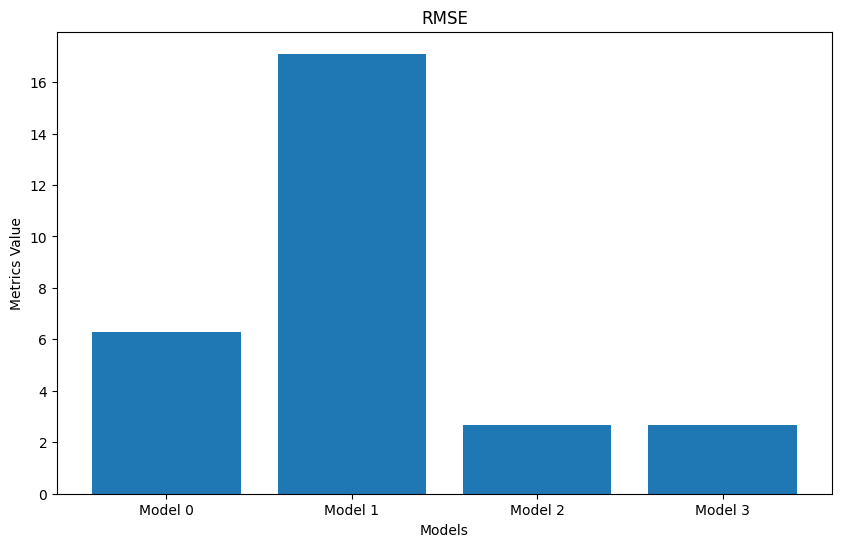

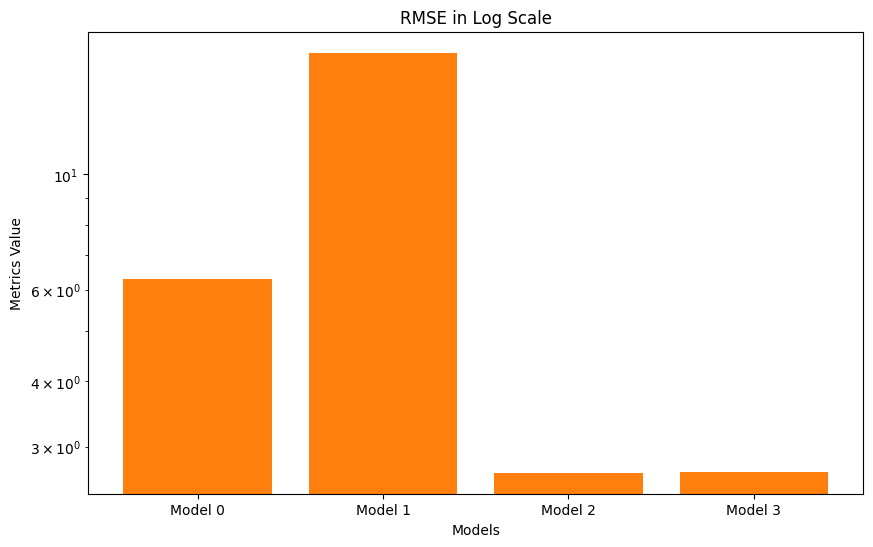

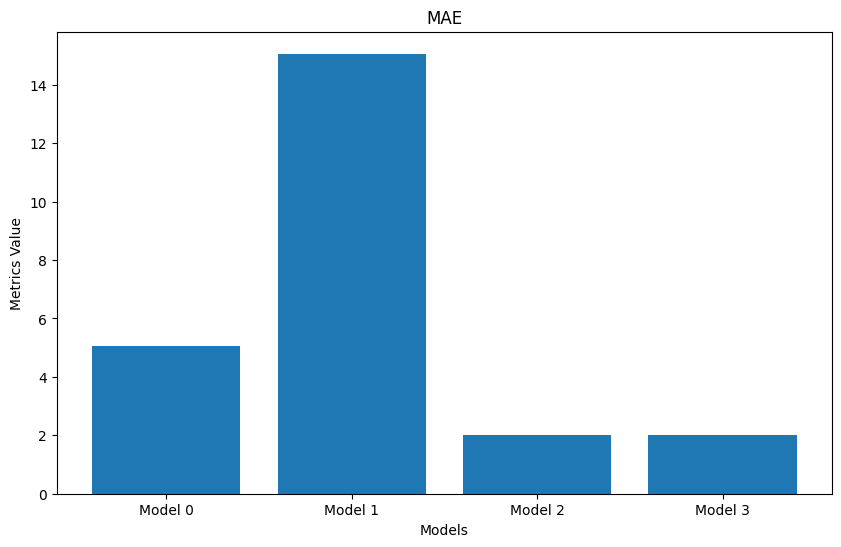

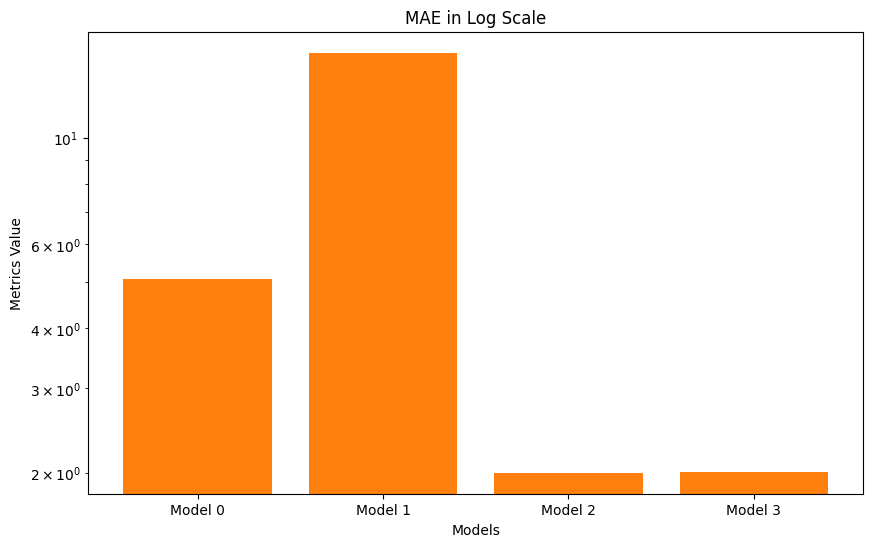

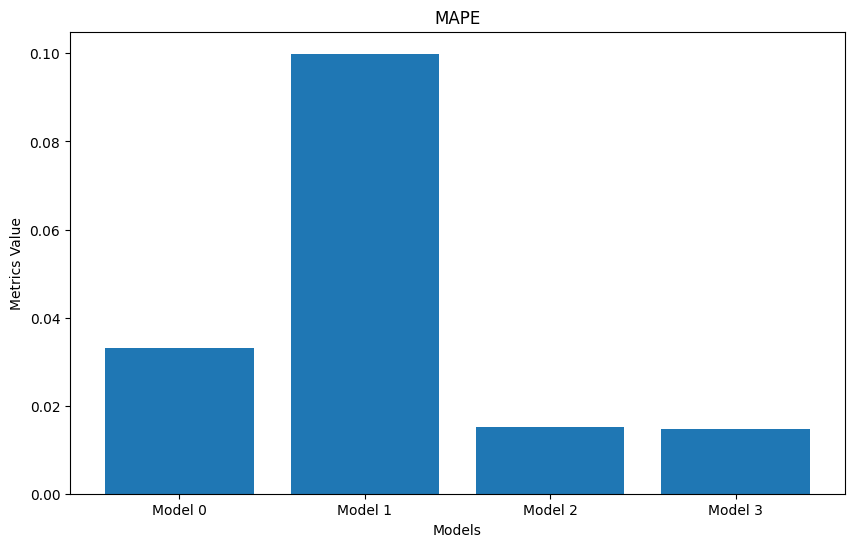

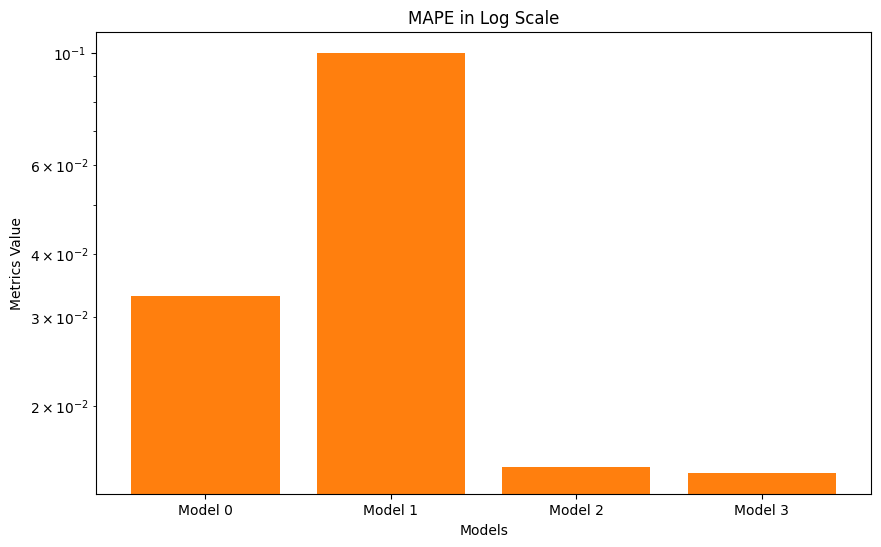

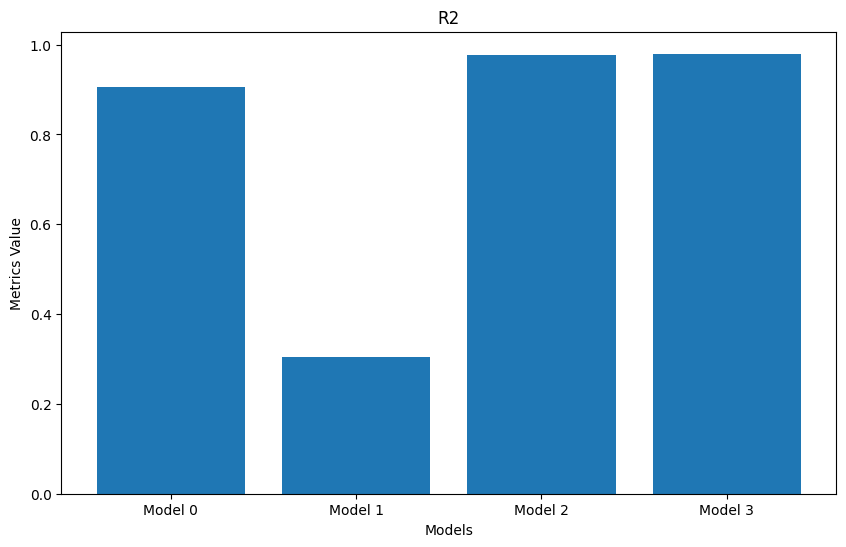

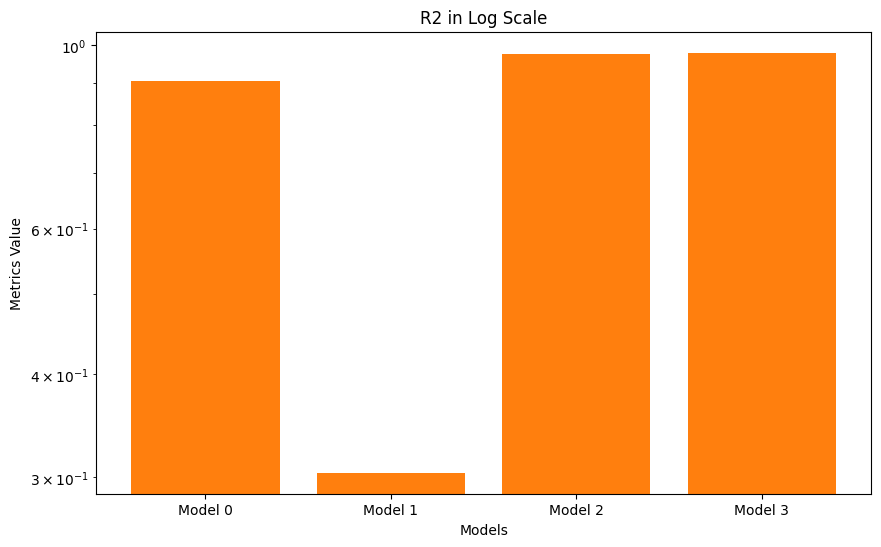

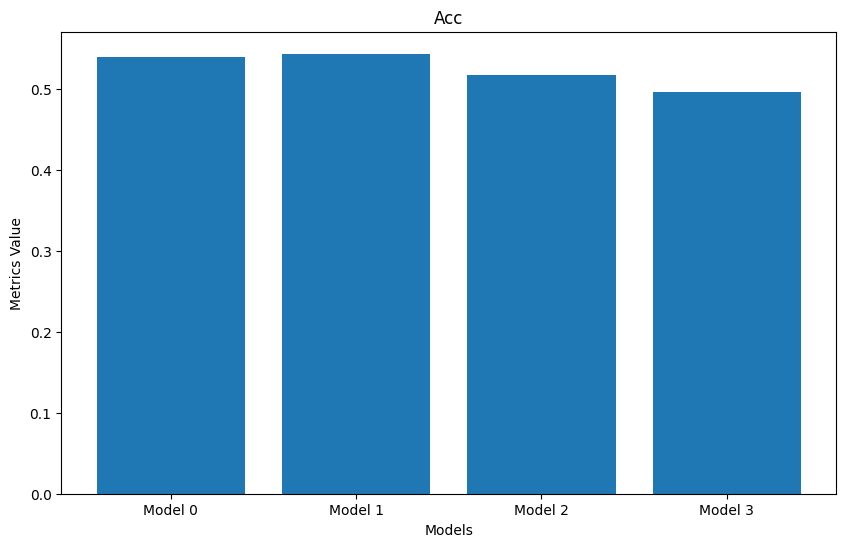

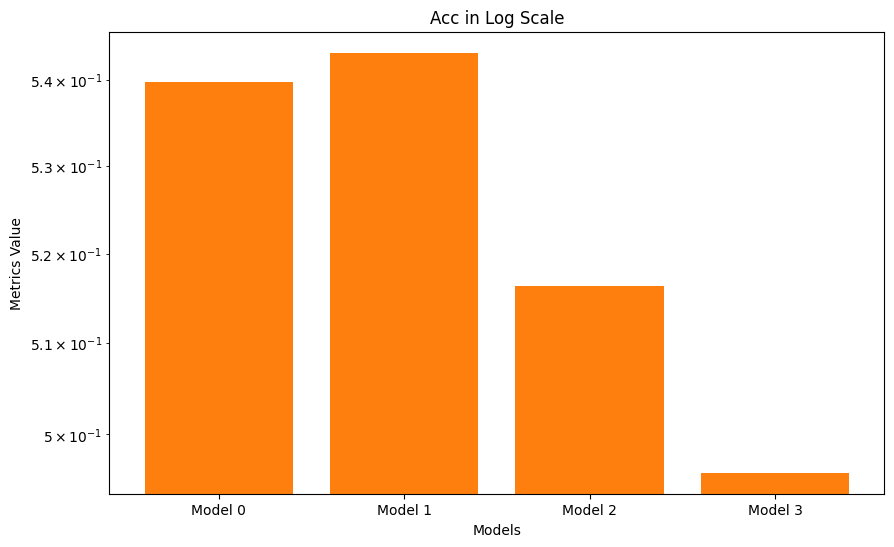

In [ ]:
# Section by Parameter
metrics = ["RMSE", "MAE", "MAPE", "R2", "Acc"]

evaluation = {
    "RMSE": {},
    "MAE": {},
    "MAPE": {},
    "R2": {},
    "Acc": {},
}

for model_idx, cv_score in enumerate(cv_scores):
    for param in metrics:
        evaluation[param][f"Model {model_idx}"] = cv_score[param].mean()

for param in metrics:
    plt.figure(figsize=(10,6))
    plt.title(param)
    plt.bar(list(evaluation[param].keys()), list(evaluation[param].values()))
    plt.xlabel("Models")
    plt.ylabel("Metrics Value")
    plt.show()

    plt.figure(figsize=(10,6))
    plt.title(param + " in Log Scale")
    plt.bar(list(evaluation[param].keys()), list(evaluation[param].values()), color="tab:orange")
    plt.xlabel("Models")
    plt.ylabel("Metrics Value")
    plt.yscale('log')
    plt.show()

In [ ]:
# Output complete results
for i, cv_score in enumerate(cv_scores):
    print(f"Model {i}")
    print(cv_score)

Model 0
         RMSE        MAE      MAPE        R2       Acc
0    0.946975   0.726690  0.018340  0.927976  0.508889
1    1.061546   0.801504  0.019457  0.929853  0.513333
2    1.129189   0.860011  0.020445  0.918401  0.511111
3    1.217889   0.947066  0.022017  0.913549  0.515556
4    1.254960   0.997860  0.022958  0.907413  0.508889
5    1.294982   1.044843  0.023665  0.911723  0.522222
6    1.402754   1.150983  0.025443  0.919349  0.531111
7    1.495261   1.239897  0.026609  0.921004  0.526667
8    1.603737   1.351731  0.028100  0.918460  0.531111
9    1.585230   1.342565  0.027016  0.928403  0.520000
10   0.711703   0.513975  0.010725  0.987062  0.528889
11   0.715401   0.514688  0.010341  0.988632  0.542222
12   0.745239   0.551974  0.010596  0.987799  0.533333
13   0.690950   0.512733  0.009647  0.991434  0.535556
14   1.167474   0.956847  0.016254  0.981030  0.555556
15   0.709580   0.499402  0.008601  0.994607  0.555556
16   1.455281   1.081319  0.016167  0.982731  0.546667
17